# Bench Plotting
Given the output from the benchmarking pipeline, this notebook plots relevant figures given the path to the output CSVs. 


In [1]:
import pandas
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set(style="whitegrid", palette="pastel", rc={"figure.dpi":300, 'savefig.dpi':300})

# Define color palette

In [2]:
plot_title_color = "#3f007d"
plot_axis_color = "#3f007d"
project_colors = ['#efedf5', '#dadaeb', '#bcbddc', '#9e9ac8', '#807dba', '#6a51a3', '#54278f', '#3f007d']

project_colors += project_colors[::-1]
sns.set_palette(project_colors)

## Helper Methods

In [3]:
def csv2dataframe(csv_file):
    """
    Converts the csv file to a pandas dataframe.
    """
    return pandas.read_csv(csv_file)

---
---
## *A - Performance Testing*
---
---

### A.1 - parsing csv

In [85]:
performance_csv = "../results/res_performance_benchmarking3.csv"

In [86]:
# open dataframe
df = csv2dataframe(performance_csv)
df.describe()

genome count  number of reads  build time (ns)  build mem (bytes)  \
count     40.000000        40.000000     4.000000e+01          40.000000   
mean      55.000000     27775.000000     1.374739e+09       37295.600000   
std       29.088724     42411.922308     7.445603e+08        4664.467567   
min       10.000000       100.000000     2.526415e+08       26104.000000   
25%       30.000000       775.000000     9.020178e+08       35992.000000   
50%       55.000000      5500.000000     1.225662e+09       36720.000000   
75%       80.000000     32500.000000     2.025335e+09       39960.000000   
max      100.000000    100000.000000     2.514259e+09       44032.000000   

       query time (ns)  query memory (bytes)  classification recall  \
count     4.000000e+01              40.00000                   40.0   
mean      2.836933e+09           39003.70000                    1.0   
std       4.620344e+09            3852.66271                    0.0   
min       2.813851e+07           26852.00000                    1.0   
25%       1.136985e+08           36013.00000                    1.0   
50%       3.171889e+08           40540.00000                    1.0   
75%       2.404429e+09           40540.00000                    1.0   
max       1.585865e+10           44720.00000                    1.0   

       classification precision  filter recall  filter precision  \
count                 40.000000      40.000000         40.000000   
mean                   0.607966       0.999603          0.999808   
std                    0.208779       0.002510          0.000333   
min                    0.344828       0.984125          0.998752   
25%                    0.452020       1.000000          0.999759   
50%                    0.514706       1.000000          1.000000   
75%                    0.762500       1.000000          1.000000   
max                    1.000000       1.000000          1.000000   

       avg. read count error  
count              40.000000  
mean               13.210278  
std                67.381818  
min                 0.000000  
25%                 0.000000  
50%                 0.000000  
75%                 0.135417  
max               425.750000

In [87]:
# transform
df["Build Memory (MB)"] = df["build mem (bytes)"] / (10)**3
df["Build Time (seconds)"] = df["build time (ns)"] / (10**9)
df["Query Memory (MB)"] = df["query memory (bytes)"] / (10)**3
df["Query Time (seconds)"] = df["query time (ns)"] / (10**9)
df["F1"] = 2* df["classification precision"]*df["classification recall"] / (df["classification precision"]+df["classification recall"])

### A.2 - plotting

In [88]:
# Pivot the dataframe to create a matrix of query memory values
matrix1 = df.pivot(index='genome count', columns='number of reads', values=f"Query Memory (MB)")
# Pivot the dataframe to create a matrix of query time values
matrix2 = df.pivot(index='genome count', columns='number of reads', values=f"Query Time (seconds)")

# Set the figure size and create the subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Create the first heatmap
sns.heatmap(matrix1, annot=True, fmt=".0f", cmap=project_colors, ax=axs[0])

# Set the title and axis labels for the first heatmap
axs[0].set_title(f"Query Memory (MB)", color=plot_title_color)
axs[0].set_xlabel("# of reads", color=plot_axis_color)
axs[0].set_ylabel("# of genomes", color=plot_axis_color)

# Create the second heatmap
sns.heatmap(matrix2, annot=True, fmt=".0f", cmap=project_colors, ax=axs[1])

# Set the title and axis labels for the second heatmap
axs[1].set_title(f"Query Time (seconds)", color=plot_title_color)
axs[1].set_xlabel("# of reads", color=plot_axis_color)
axs[1].set_ylabel("# of genomes", color=plot_axis_color)

# Adjust the spacing between the subplots
fig.subplots_adjust(wspace=0.2)

# Show the plot
plt.show()

In [89]:
df_groupbyreads =  df.groupby(["genome count"], as_index=False).mean()


fig, ax1 = plt.subplots(figsize=(4, 3))
ax2 = ax1.twinx()

# add data
ax1.scatter(df_groupbyreads["genome count"], df_groupbyreads["Build Memory (MB)"], s=50, color=project_colors[0], label="memory")
ax2.scatter(df_groupbyreads["genome count"], df_groupbyreads["Build Time (seconds)"], s=30, color=project_colors[-4], edgecolor="black", label="time")

# configure axis labels
plt.title('Performance building gSBT', size=10, color=plot_title_color)
ax1.set_xlabel('Number of genomes added to gSBT', size=10)
ax1.set_ylabel('Memory to build gSBT (MB)', size=10, color=project_colors[0])
ax2.set_ylabel('Time to build gSBT (seconds)', size=10, color=project_colors[-4])
plt.show()

## A.3 - Running time per number of reads (number of genomes as legend)

In [90]:
fig, ax1 = plt.subplots(figsize=(6, 3))

# group by genome count
df_groupbyreads =  df.groupby(["genome count"], as_index=False).mean()

# add data
number_of_reads = len(pandas.unique(df["genome count"]))
sns.lineplot(data=df, x="number of reads", y="Query Time (seconds)", palette=project_colors[:number_of_reads], hue="genome count")

# put legend on the right
legend = ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
legend.set_title("Genome Count")

# configure axis labels
plt.title('Performance building gSBT', size=10, color=plot_title_color)
ax1.set_xlabel('Number reads in query', size=10, color=plot_axis_color)
ax1.set_ylabel('Time to query gSBT (seconds)', size=10, color=plot_axis_color)
plt.show()

### Query time per gSBT size

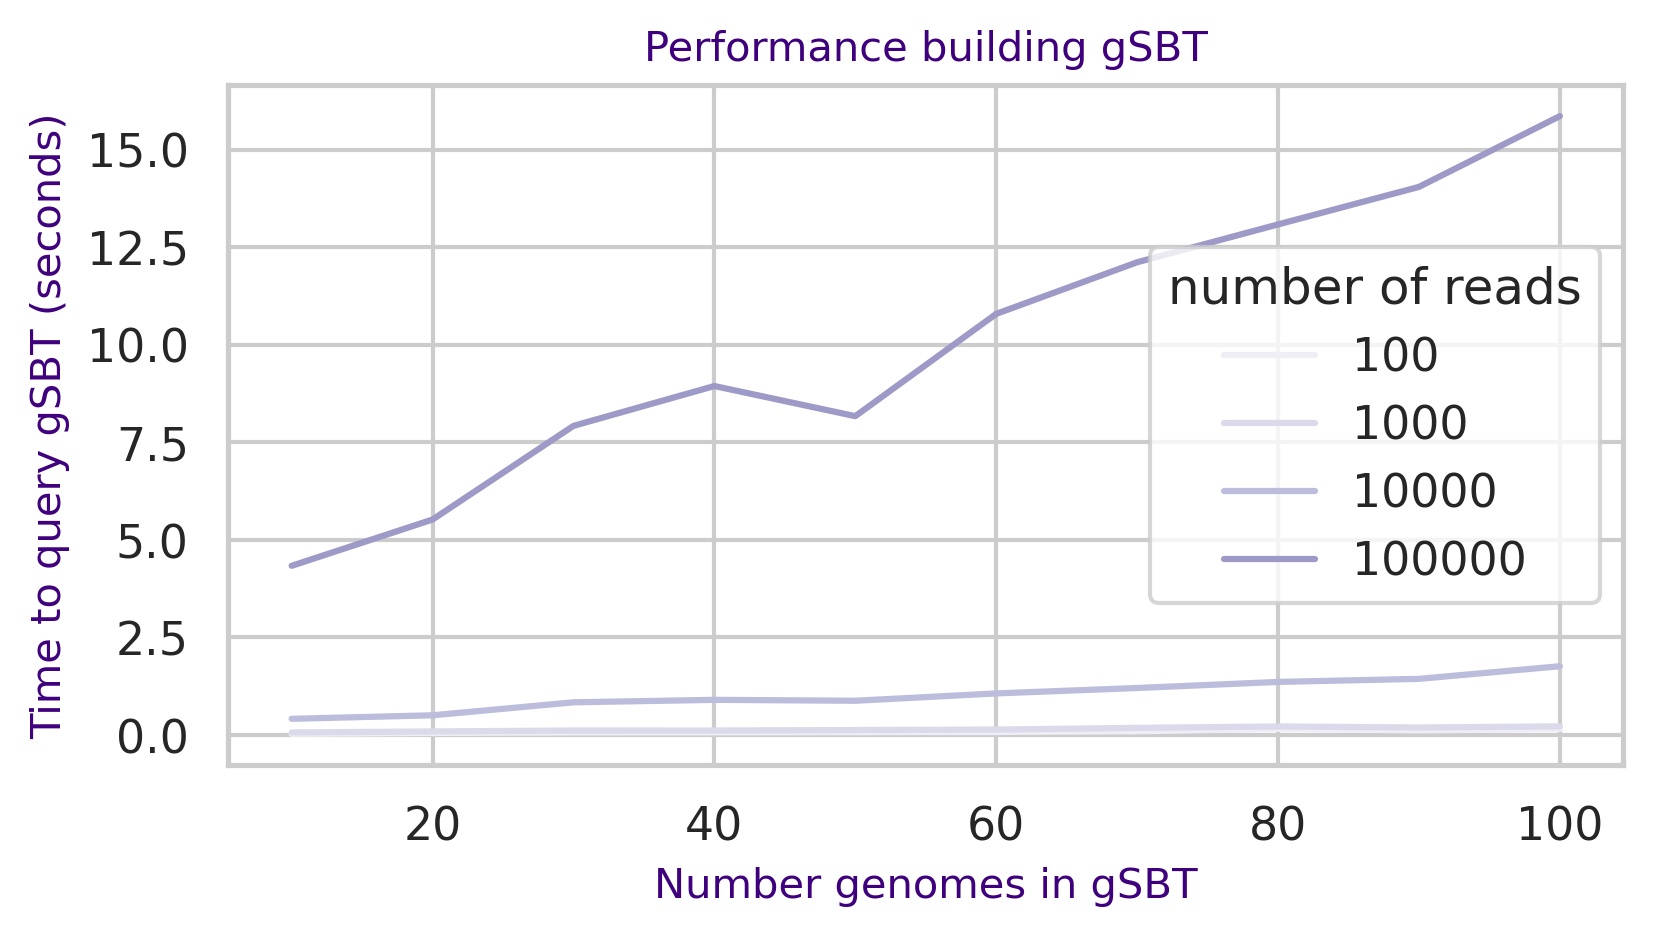

In [92]:
fig, ax1 = plt.subplots(figsize=(6, 3))

# group by genome count
df_groupbyreads =  df.groupby(["genome count"], as_index=False).mean()

# add data
color_count = len(pandas.unique(df["number of reads"]))
sns.lineplot(data=df, x="genome count", y="Query Time (seconds)", hue="number of reads", palette=project_colors[:color_count])

# configure axis labels
plt.title('Performance building gSBT', size=10, color=plot_title_color)
ax1.set_xlabel('Number genomes in gSBT', size=10, color=plot_axis_color)
ax1.set_ylabel('Time to query gSBT (seconds)', size=10, color=plot_axis_color)
plt.show()

## A.4 - Classification F1 as a function of gSBT size.

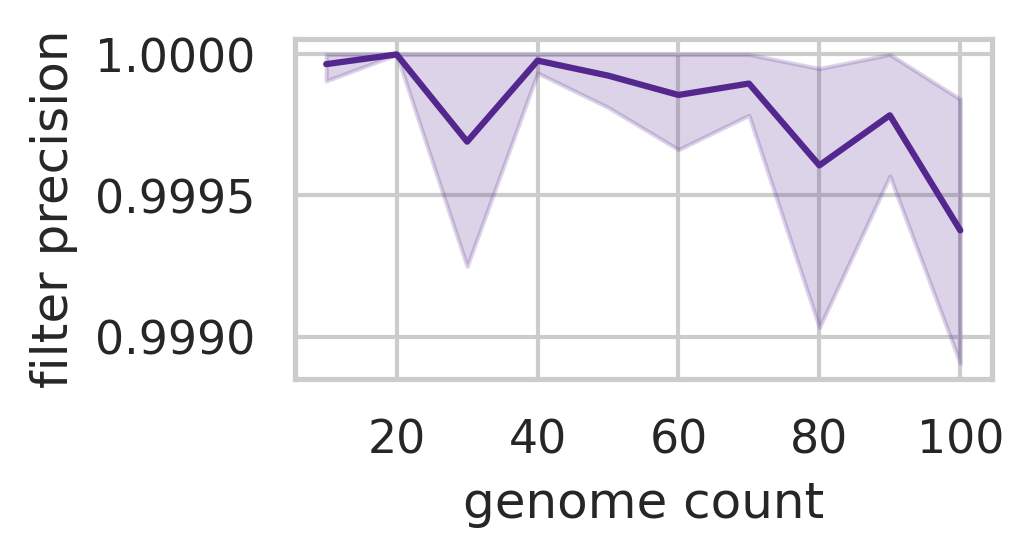

In [94]:
ax1.grid(False)

# plot
color_count = len(pandas.unique(df["number of reads"]))

fig, ax1 = plt.subplots(figsize=(3, 1.5))
sns.lineplot(data=df, x="genome count", y="classification precision", color=project_colors[9])
plt.show()


fig, ax1 = plt.subplots(figsize=(3, 1.5))
sns.lineplot(data=df, x="genome count", y="filter precision", color=project_colors[9])
plt.show()


# configure axis labels
# plt.title('Performance building gSBT ', size=10, color=plot_title_color)
# ax1.set_xlabel('Number genomes in gSBT', size=10, color=plot_axis_color)
# ax1.set_ylabel('F1', size=10, color=plot_axis_color)
# plt.show()

---
---
## B - Genomes Benchmarking(Plotting)
---
---

### B.1 - parsing

In [533]:
genomes_csv = "../results/res_genomes.csv"

In [534]:
# open dataframe
df = csv2dataframe(genomes_csv)
df.describe()

cache size  genome count     time (ns)  memory (bytes)   11  11.1  \
count   44.000000     44.000000  4.400000e+01       44.000000  0.0   0.0   
mean    41.000000     71.000000  1.090513e+10   156259.454545  NaN   NaN   
std     24.466398     23.177776  4.785910e+09    71994.327857  NaN   NaN   
min     11.000000     22.000000  2.289896e+09    54792.000000  NaN   NaN   
25%     22.000000     55.000000  7.281677e+09   104515.000000  NaN   NaN   
50%     33.000000     77.000000  1.058424e+10   146588.000000  NaN   NaN   
75%     55.000000     88.000000  1.401057e+10   214234.000000  NaN   NaN   
max     99.000000     99.000000  2.452845e+10   314856.000000  NaN   NaN   

       889553960  46704  
count        0.0    0.0  
mean         NaN    NaN  
std          NaN    NaN  
min          NaN    NaN  
25%          NaN    NaN  
50%          NaN    NaN  
75%          NaN    NaN  
max          NaN    NaN

In [535]:
# transformation
df["Memory (MB)"] = df["memory (bytes)"] / (10)**3
df["Time (minutes)"] = df["time (ns)"] / (10**9 * 60)

### B.2 - plotting

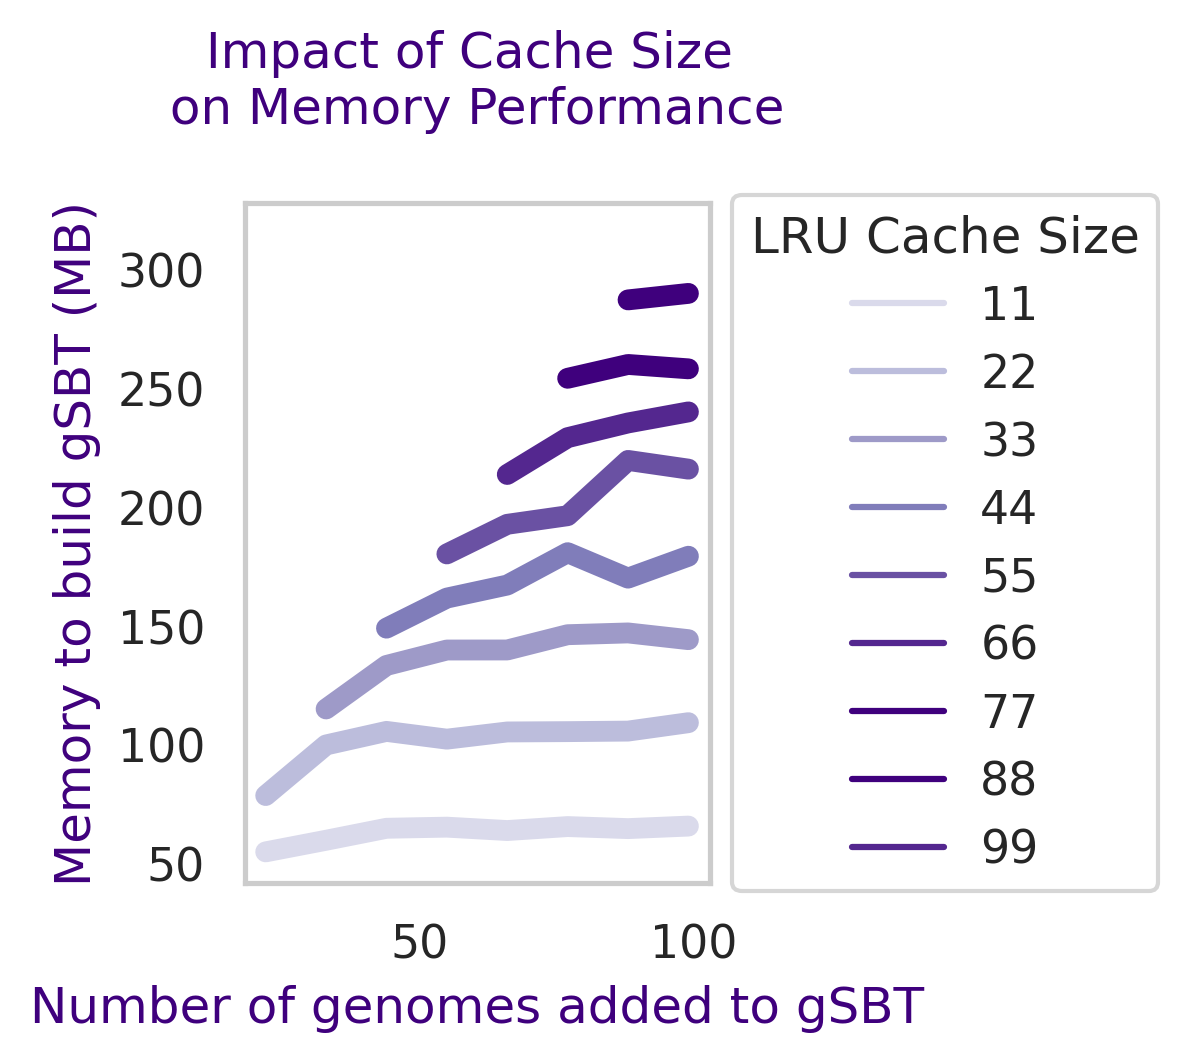

In [536]:
fig, ax1 = plt.subplots(figsize=(2, 3))
ax1.grid(False)

# add data
color_count = len(pandas.unique(df["cache size"]))
sns.lineplot(data=df, x="genome count", y="Memory (MB)", linewidth = 5, hue="cache size", palette=project_colors[1:1+color_count])

# add legend to right side
legend = ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5), fancybox=True)
legend.set_title("LRU Cache Size")

# configure axis labels
plt.title('Impact of Cache Size \n on Memory Performance \n', color=plot_title_color)
ax1.set_xlabel('Number of genomes added to gSBT', color=plot_axis_color)
ax1.set_ylabel('Memory to build gSBT (MB)', color=plot_axis_color)
plt.show()

---
---
## C - Parameterization Benchmarking (Plotting)
---
---

### C.1 - parsing

In [25]:
pameterization_csv = "../results/res_parameterization7.csv"

In [26]:
# open dataframe
df = csv2dataframe(pameterization_csv)
df.describe()

replicate    kmer size        theta   error rate  number of genomes  \
count     2400.0  2400.000000  2400.000000  2400.000000             2400.0   
mean         1.0    27.500000     0.450000     0.050000               50.0   
std          0.0    11.458827     0.287288     0.034164                0.0   
min          1.0    10.000000     0.000000     0.000000               50.0   
25%          1.0    18.750000     0.200000     0.020000               50.0   
50%          1.0    27.500000     0.450000     0.050000               50.0   
75%          1.0    36.250000     0.700000     0.080000               50.0   
max          1.0    45.000000     0.900000     0.100000               50.0   

       read count          time        memory  classification recall  \
count      2400.0  2.400000e+03   2400.000000            2400.000000   
mean       1000.0  2.440321e+08  27701.048333               0.868530   
std           0.0  1.365375e+08    561.211862               0.273812   
min        1000.0  3.505851e+07  26760.000000               0.000000   
25%        1000.0  1.408628e+08  27576.000000               0.940000   
50%        1000.0  2.417142e+08  27776.000000               1.000000   
75%        1000.0  3.002095e+08  27860.000000               1.000000   
max        1000.0  1.028822e+09  30060.000000               1.000000   

       classification precision  filter recall  filter precision  \
count               2400.000000    2400.000000       2400.000000   
mean                   0.828016       0.530456          0.907907   
std                    0.286411       0.406042          0.206320   
min                    0.000000       0.000000          0.000000   
25%                    0.833333       0.099747          0.992395   
50%                    1.000000       0.489000          1.000000   
75%                    1.000000       1.000000          1.000000   
max                    1.000000       1.000000          1.000000   

       avg read count error  
count           2363.000000  
mean             155.279793  
std              279.496436  
min                0.000000  
25%                4.577778  
50%               11.800000  
75%               99.000000  
max              988.000000

In [27]:
# transformations
df["F1"] = 2* df["classification precision"]*df["classification recall"] / (df["classification precision"]+df["classification recall"])
df["filter F1"] = 2* df["filter precision"]*df["filter recall"] / (df["filter precision"]+df["filter recall"])
df["read count error"] = pandas.to_numeric(df["avg read count error"].replace("nan", np.nan))

In [28]:
# df =  df.groupby(["kmer size", " theta"], as_index=False).mean()
# df2 =  df.groupby(["kmer size", "number of genomes"], as_index=False).mean()
# df4 =  df.groupby(["theta", "error rate"], as_index=False).mean()
# df =  df.groupby(["kmer size", "theta", "error rate", "number of genomes"], as_index=False).min()

### C.2 - plotting

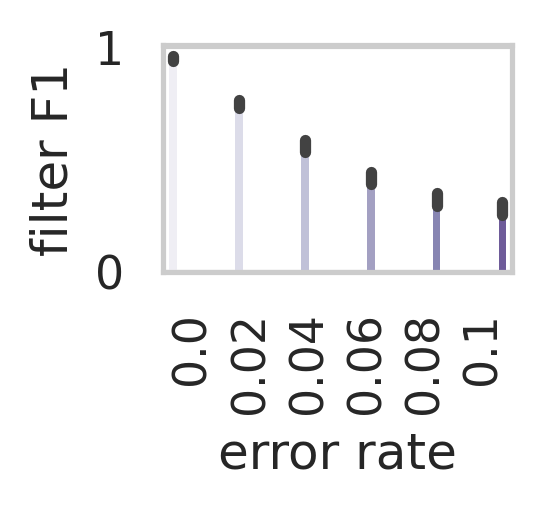

In [29]:
fig, ax1 = plt.subplots(figsize=(1.5, 1))
ax = sns.barplot(data=df, x="error rate", y="filter F1", hue="error rate", lw=0.001, palette=project_colors)
ax.xaxis.set_tick_params(rotation=90)
ax.legend_.remove()
# legend = ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# legend.set_title("Error Rate")

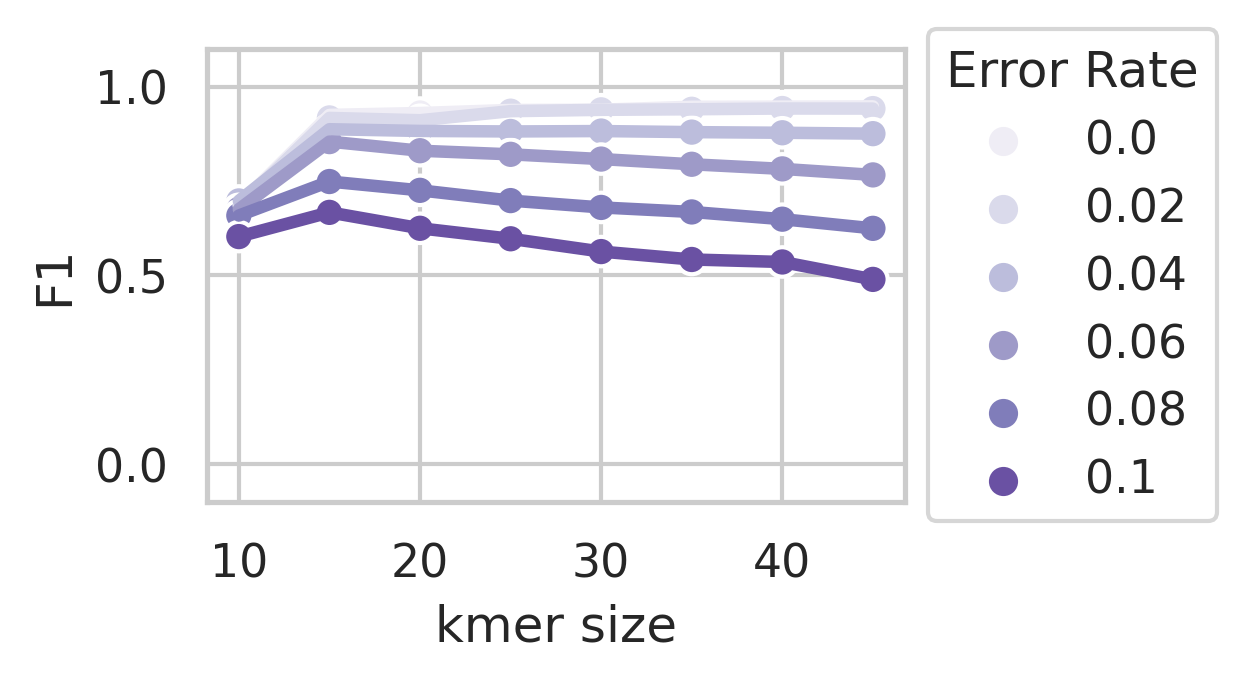

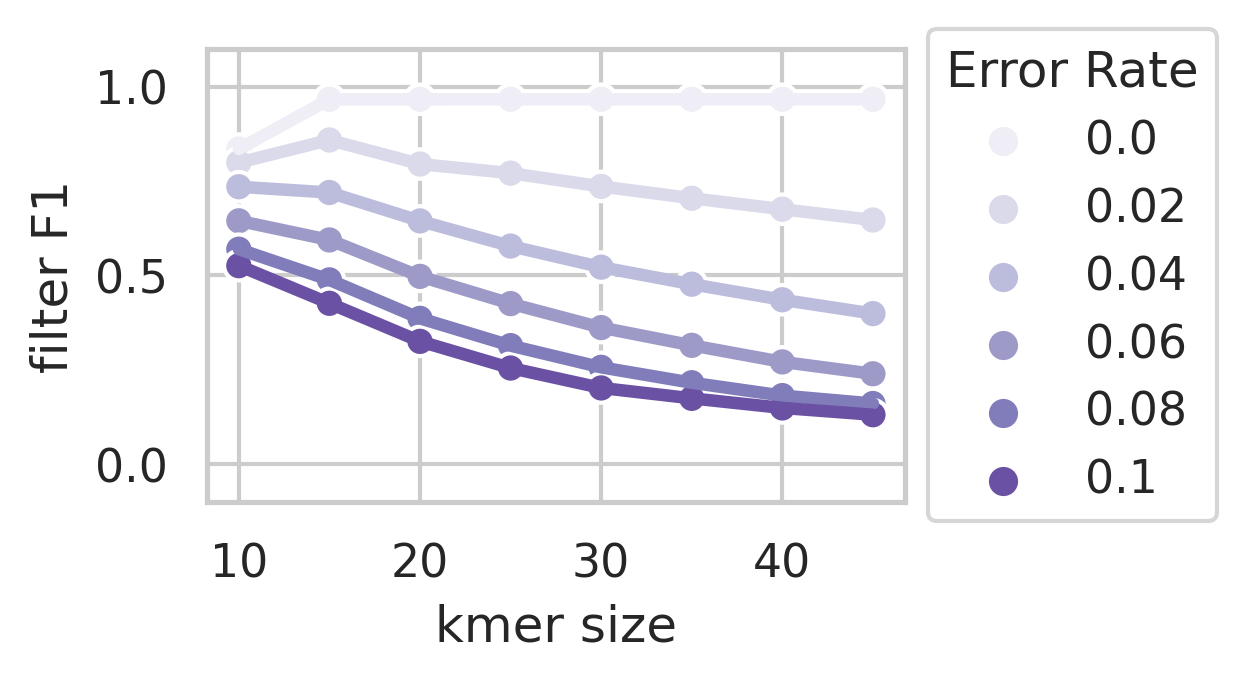

In [42]:
# plot-specific data transformation
df3 =  df.groupby(["kmer size", "error rate"], as_index=False).mean()

# plot

fig, ax1 = plt.subplots(figsize=(3, 2))
color_count = len(pandas.unique(df3["error rate"]))
ax = sns.scatterplot(data=df3, x="kmer size", y="F1", linewidth = 1, hue="error rate", s=50, palette=project_colors[:color_count])
ax = sns.lineplot(data=df3,  x="kmer size", y="F1", hue="error rate", linewidth = 3, palette=project_colors[:color_count], legend=False)
ax.set_ylim(bottom=-0.1, top=1.1)
legend = ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
legend.set_title("Error Rate")


fig, ax1 = plt.subplots(figsize=(3, 2))
color_count = len(pandas.unique(df3["error rate"]))
ax = sns.scatterplot(data=df3, x="kmer size", y="filter F1", linewidth = 1, hue="error rate", s=50, palette=project_colors[:color_count])
ax = sns.lineplot(data=df3,  x="kmer size", y="filter F1", hue="error rate", linewidth = 3, palette=project_colors[:color_count], legend=False)
ax.set_ylim(bottom=-0.1, top=1.1)
legend = ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
legend.set_title("Error Rate")

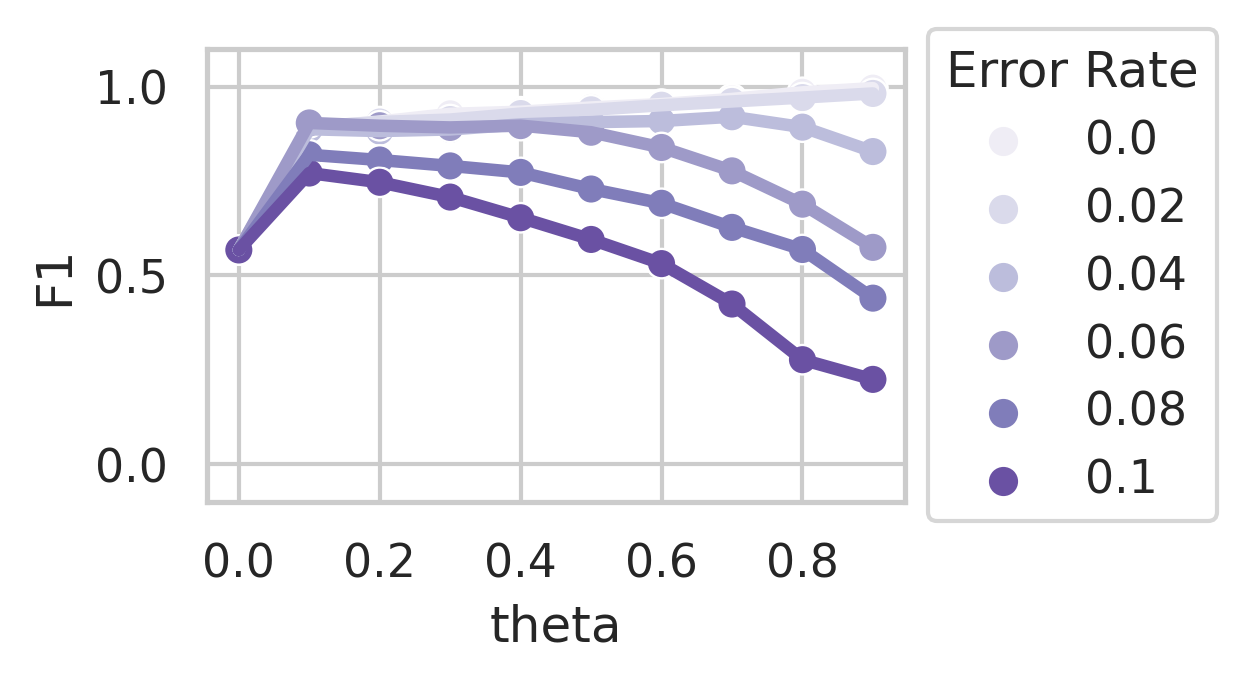

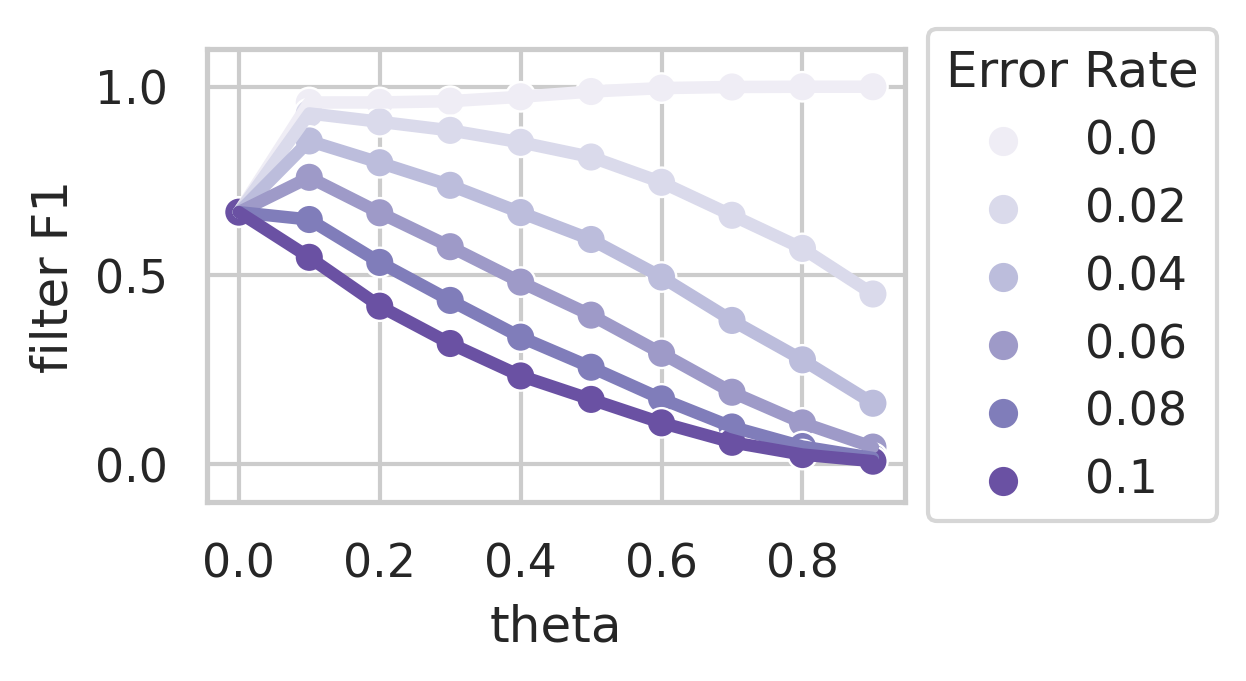

In [43]:
# plot-specific data transformation
df4 =  df.groupby(["theta", "error rate"], as_index=False).mean()

# plot
fig, ax1 = plt.subplots(figsize=(3, 2))
color_count = len(pandas.unique(df4["error rate"]))
ax = sns.scatterplot(data=df4, x="theta", y="F1", hue="error rate", s=50, palette=project_colors[0:color_count])
ax = sns.lineplot(data=df4, x="theta", y="F1", hue="error rate", linewidth = 3, palette=project_colors[0:color_count], legend=False)
ax.set_ylim(bottom=-0.1, top=1.1)
legend = ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
legend.set_title("Error Rate")

fig, ax1 = plt.subplots(figsize=(3, 2))
color_count = len(pandas.unique(df4["error rate"]))
ax = sns.scatterplot(data=df4, x="theta", y="filter F1", hue="error rate", s=50, palette=project_colors[0:color_count])
ax = sns.lineplot(data=df4, x="theta", y="filter F1", hue="error rate", linewidth = 3, palette=project_colors[0:color_count], legend=False)
ax.set_ylim(bottom=-0.1, top=1.1)
legend = ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
legend.set_title("Error Rate")

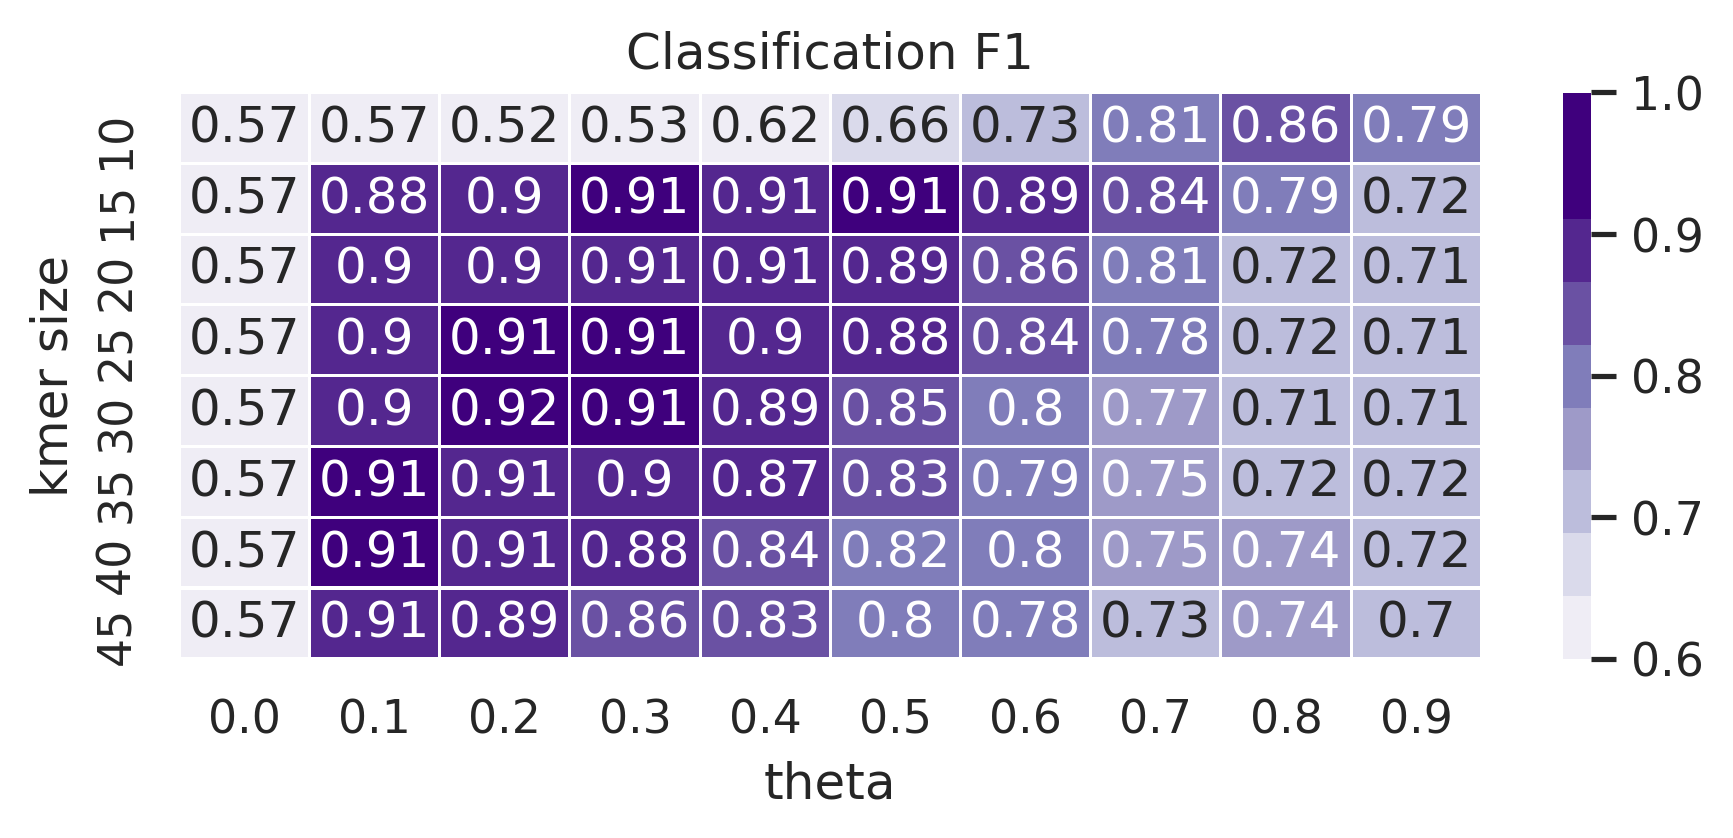

In [84]:
# plot-specific data transformation
df_heatmap = df[df["error rate"] >= 0.0]
df_heatmap = df_heatmap.groupby(["kmer size", "theta"], as_index=False).mean()
df_heatmap.describe()

# plotting
fig, ax = plt.subplots(figsize=(7, 2.5))
ax = sns.heatmap(data=df_heatmap.pivot("kmer size", "theta", "F1"), annot=True, linewidth=.5, cmap=project_colors[:9], vmin=0.6, vmax=1.0)
ax.set_title("Classification F1")
plt.show()

fig, ax = plt.subplots(figsize=(7, 2.5))
ax = sns.heatmap(data=df_heatmap.pivot("kmer size", "theta", "filter precision"), annot=True, linewidth=.5, cmap=project_colors[:9], vmin=0.6, vmax=1.0)
ax.set_title("Filter F1")
plt.show()

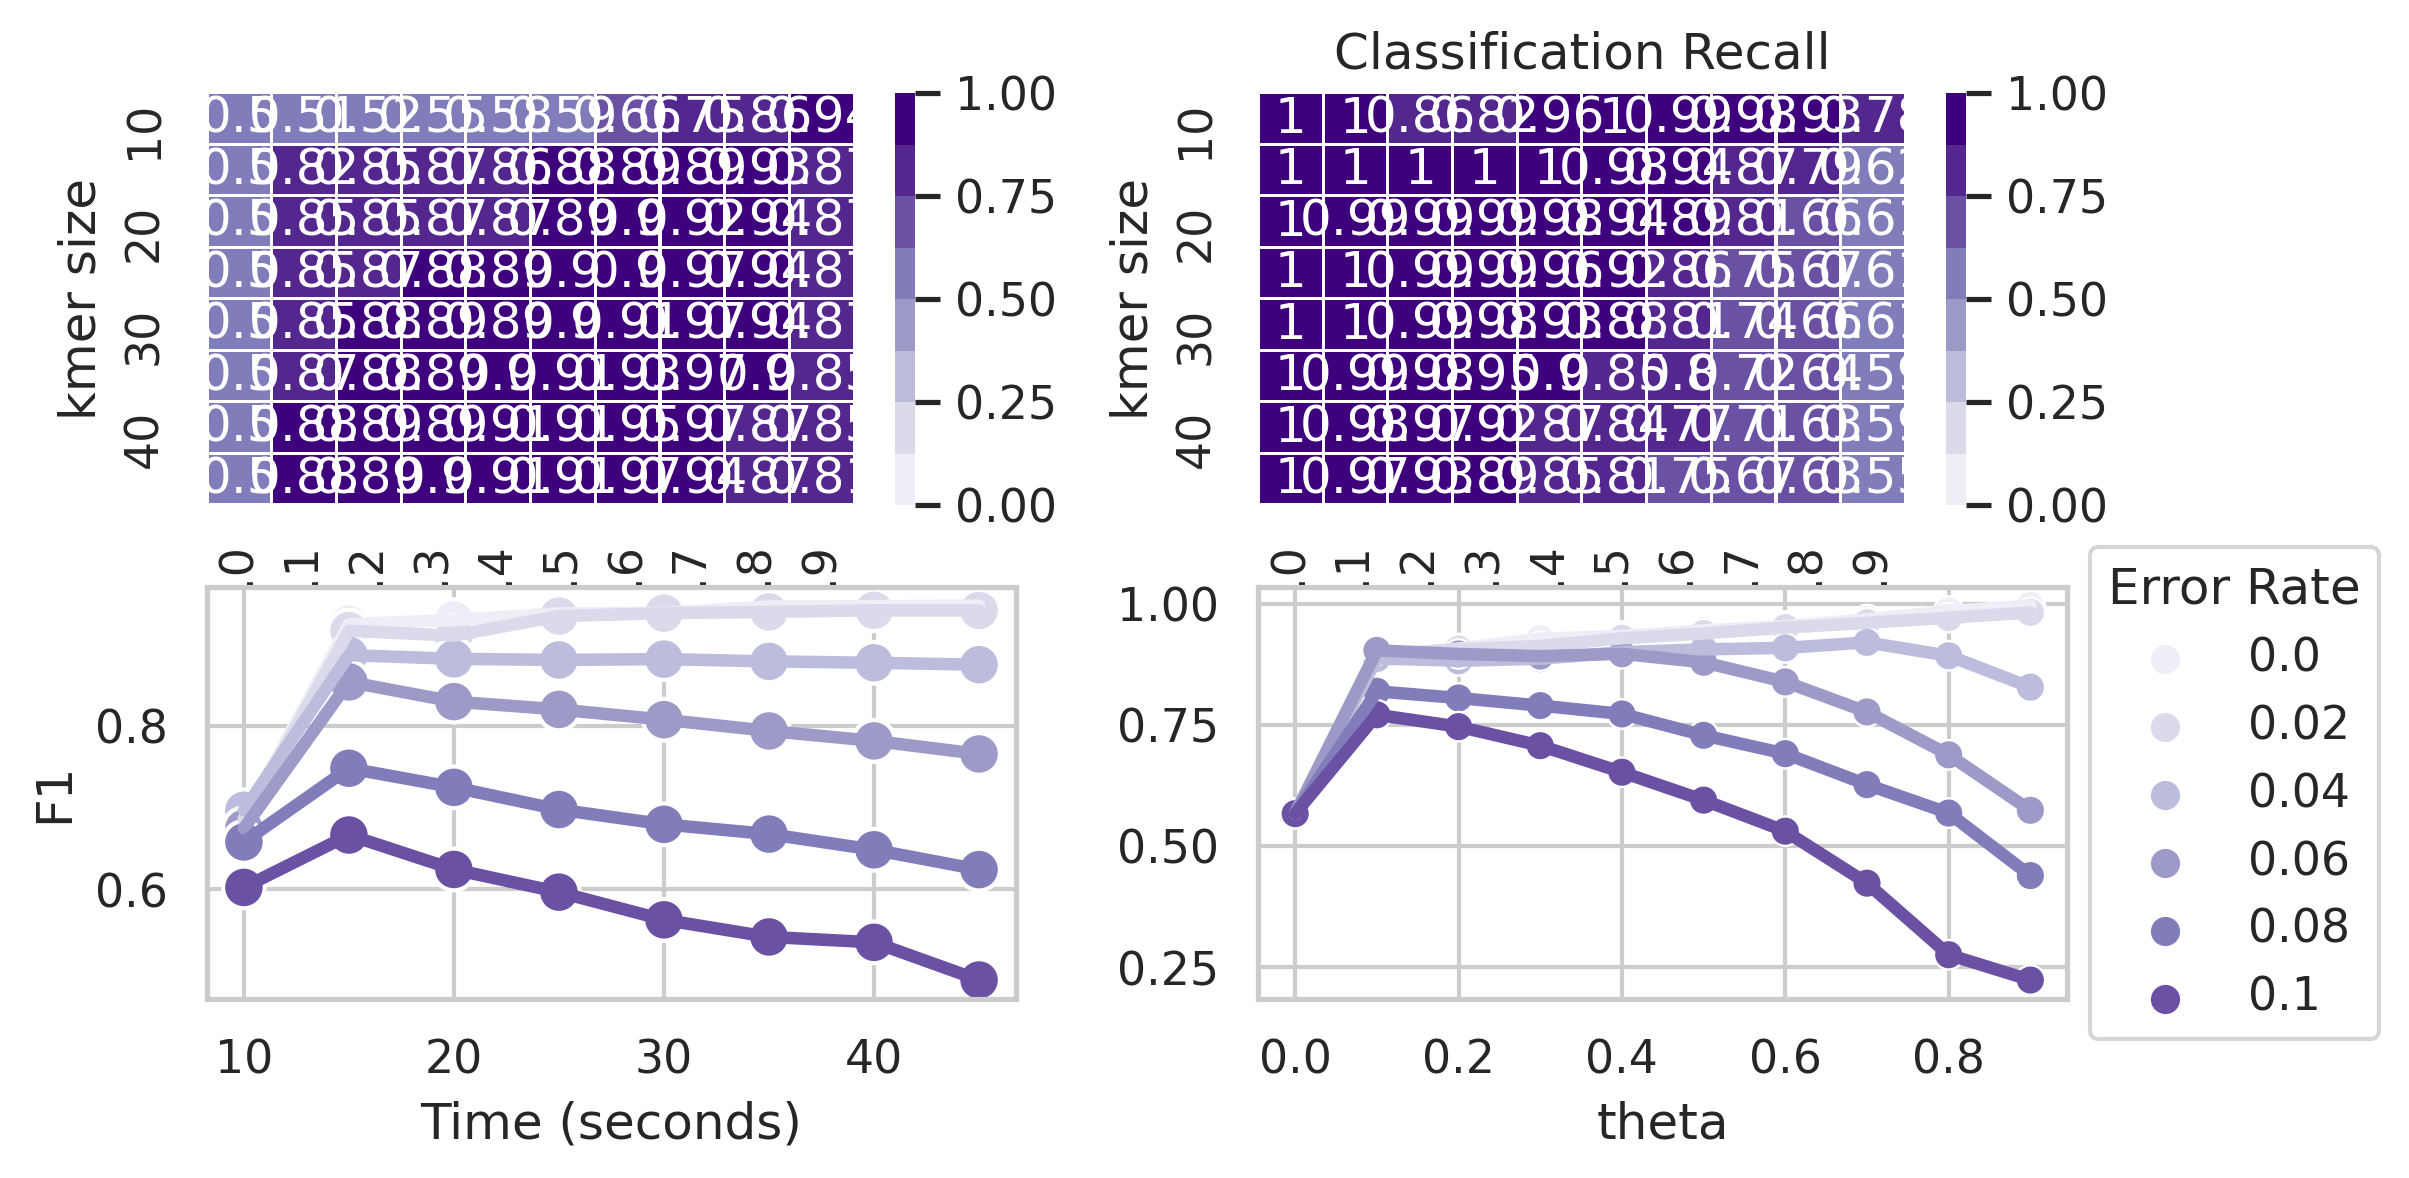

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a single figure with two subplots arranged in a single row
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=2, figsize=(8, 4))



# ax3
df_heatmap = df #[df["error rate"] < 0.1]
df_heatmap = df_heatmap.groupby(["kmer size", "theta"], as_index=False).mean()
df_heatmap.describe()
#
sns.heatmap(data=df_heatmap.pivot("kmer size", "theta", "classification precision"), annot=True, linewidth=.5, cmap=project_colors[:8], vmin=0, vmax=1.0, ax=ax1[0])
ax1[1].set_title("Classification Precision")

sns.heatmap(data=df_heatmap.pivot("kmer size", "theta", "classification recall"), annot=True, linewidth=.5, cmap=project_colors[:8], vmin=0, vmax=1.0, ax=ax1[1])
ax1[1].set_title("Classification Recall")

# Adjust the space between the two subplots
plt.subplots_adjust(wspace=2)

# First subplot: Time (seconds)
color_count = len(pandas.unique(df3["error rate"]))
sns.scatterplot(data=df3, x="kmer size", y="F1", linewidth = 1, hue="error rate", s=100, palette=project_colors[:color_count], legend=False, ax=ax2[0])
sns.lineplot(data=df3,  x="kmer size", y="F1", hue="error rate", linewidth = 3, palette=project_colors[:color_count], legend=False, ax=ax2[0])
ax2[0].set_xlabel('Time (seconds)')


# Second subplot: Memory (MB)
color_count = len(pandas.unique(df4["error rate"]))
sns.scatterplot(data=df4, x="theta", y="F1", hue="error rate", s=50, palette=project_colors[0:color_count], ax=ax2[1])
sns.lineplot(data=df4, x="theta", y="F1", hue="error rate", linewidth = 3, palette=project_colors[0:color_count], legend=False, ax=ax2[1])
legend = ax2[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
legend.set_title("Error Rate")
ax2[1].set(ylabel=None)


# Adjust the space between the two subplots
plt.subplots_adjust(wspace=0.3)

# Show the combined plot
plt.show()


---
---
## D - Relative Performance Benchmarking (Plotting)
---
---

### D.1 - parsing

In [21]:
relative_performance_csv = "../results/res_MANUALTEST6.csv"
df = csv2dataframe(relative_performance_csv)
df.describe()

genome count in reads  error rate          time         memory  \
count             216.000000  216.000000  2.160000e+02     216.000000   
mean               55.000000    0.050000  5.165600e+08  194777.888889   
std                28.467852    0.034236  4.079086e+08  194531.283509   
min                11.000000    0.000000  5.093203e+07   27076.000000   
25%                33.000000    0.020000  3.209935e+08   27100.000000   
50%                55.000000    0.050000  5.483891e+08  126778.000000   
75%                77.000000    0.080000  8.070943e+08  293298.000000   
max                99.000000    0.100000  4.048500e+09  500772.000000   

           recall   precision  read count error  
count  216.000000  216.000000        216.000000  
mean     0.993118    0.890884          2.549892  
std      0.027154    0.140809          3.569549  
min      0.777778    0.224490          0.000000  
25%      1.000000    0.822454          0.619472  
50%      1.000000    0.956522          1.510101  
75%      1.000000    1.000000          2.606061  
max      1.000000    1.000000         26.454545

In [22]:
# threshold
df["F1"] = 2* df["precision"]*df["recall"] / (df["precision"]+df["recall"])
df["Mean read count error"] = pandas.to_numeric(df["read count error"].replace("nan", np.nan))
df["Memory (MB)"] = df["memory"] / (10)**3
df["Time (seconds)"] = df["time"] / (10**9)


df = df[df["error rate"] >= 0.0]

### D.2 - plotting

<AxesSubplot:xlabel='tool name', ylabel='recall'>

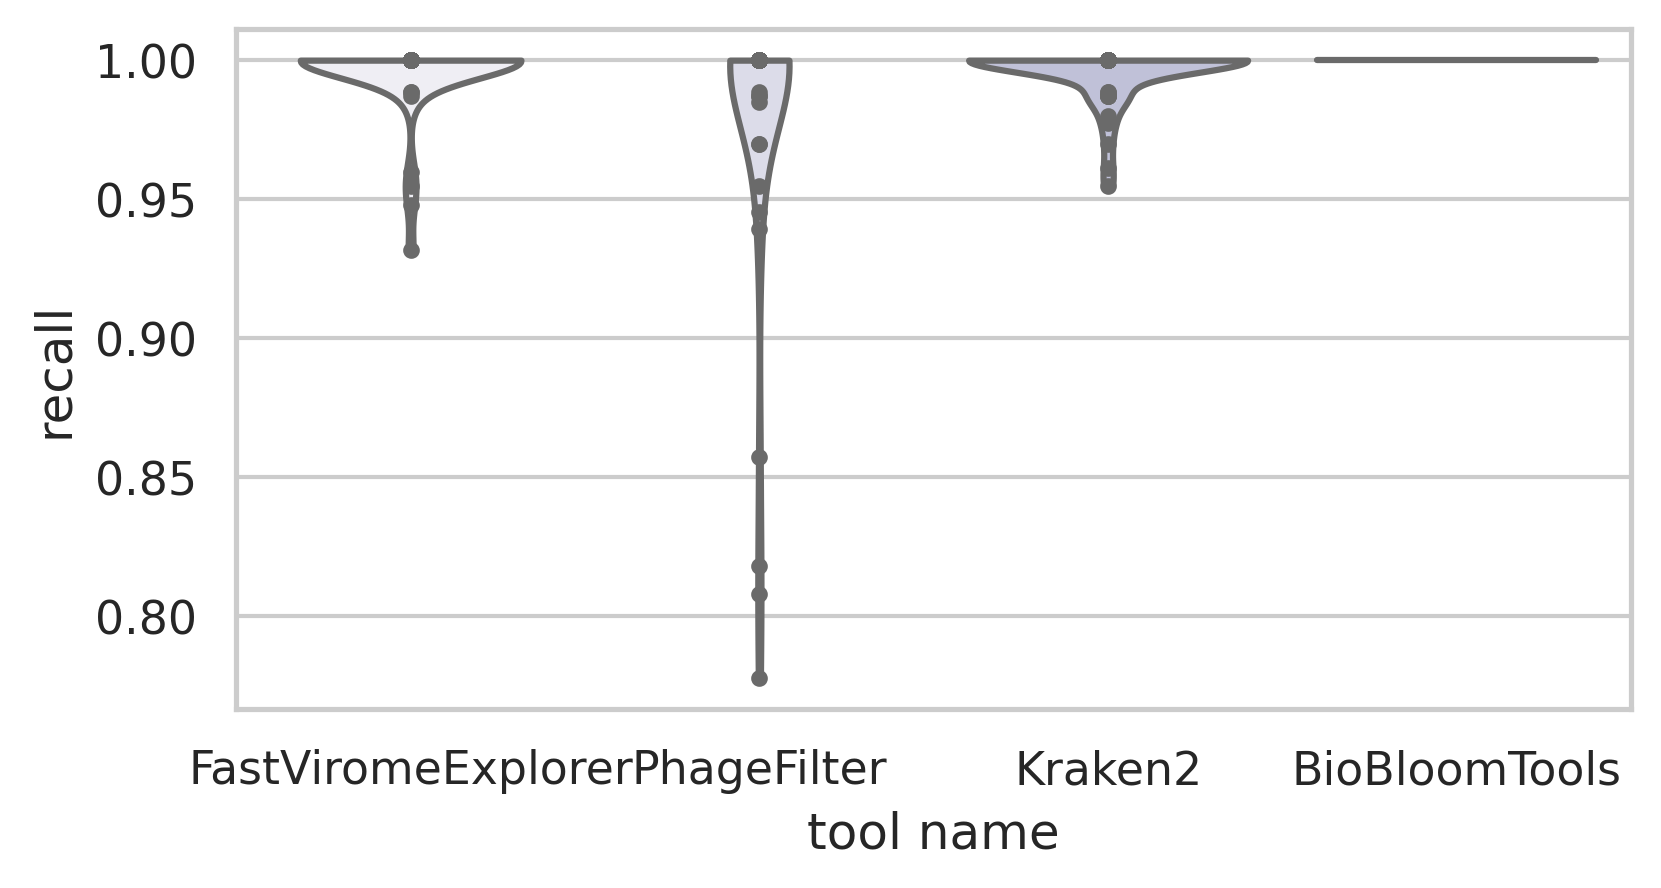

In [23]:
fig, ax1 = plt.subplots(figsize=(6, 3))
sns.violinplot(data=df, x="tool name", y="recall", cut=0, inner="point", palette=project_colors)

<AxesSubplot:xlabel='genome count in reads', ylabel='precision'>

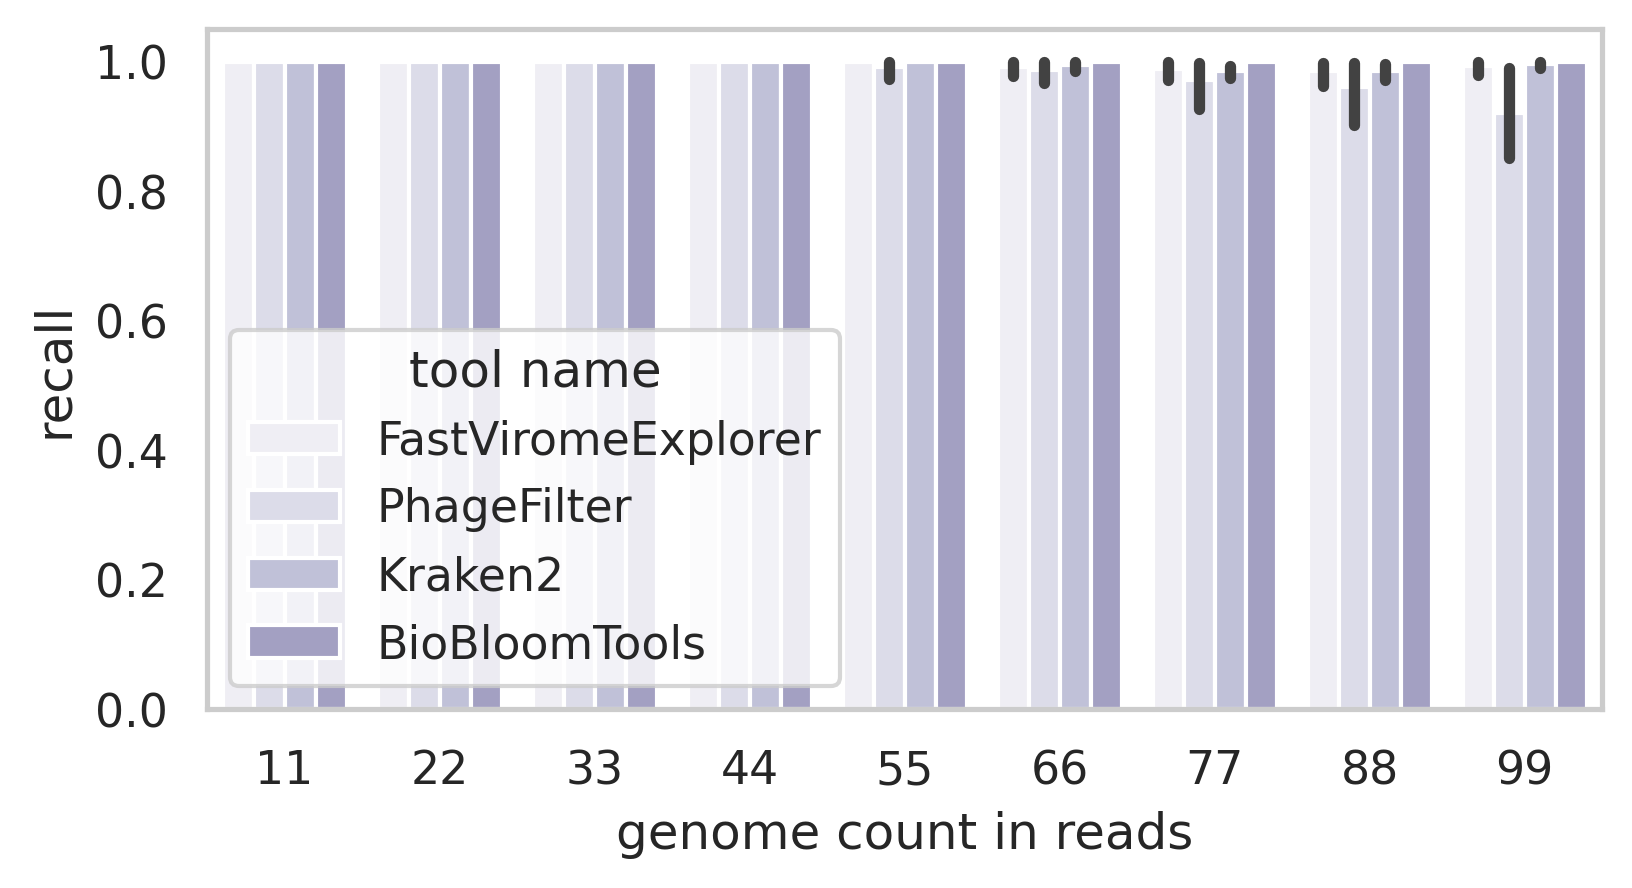

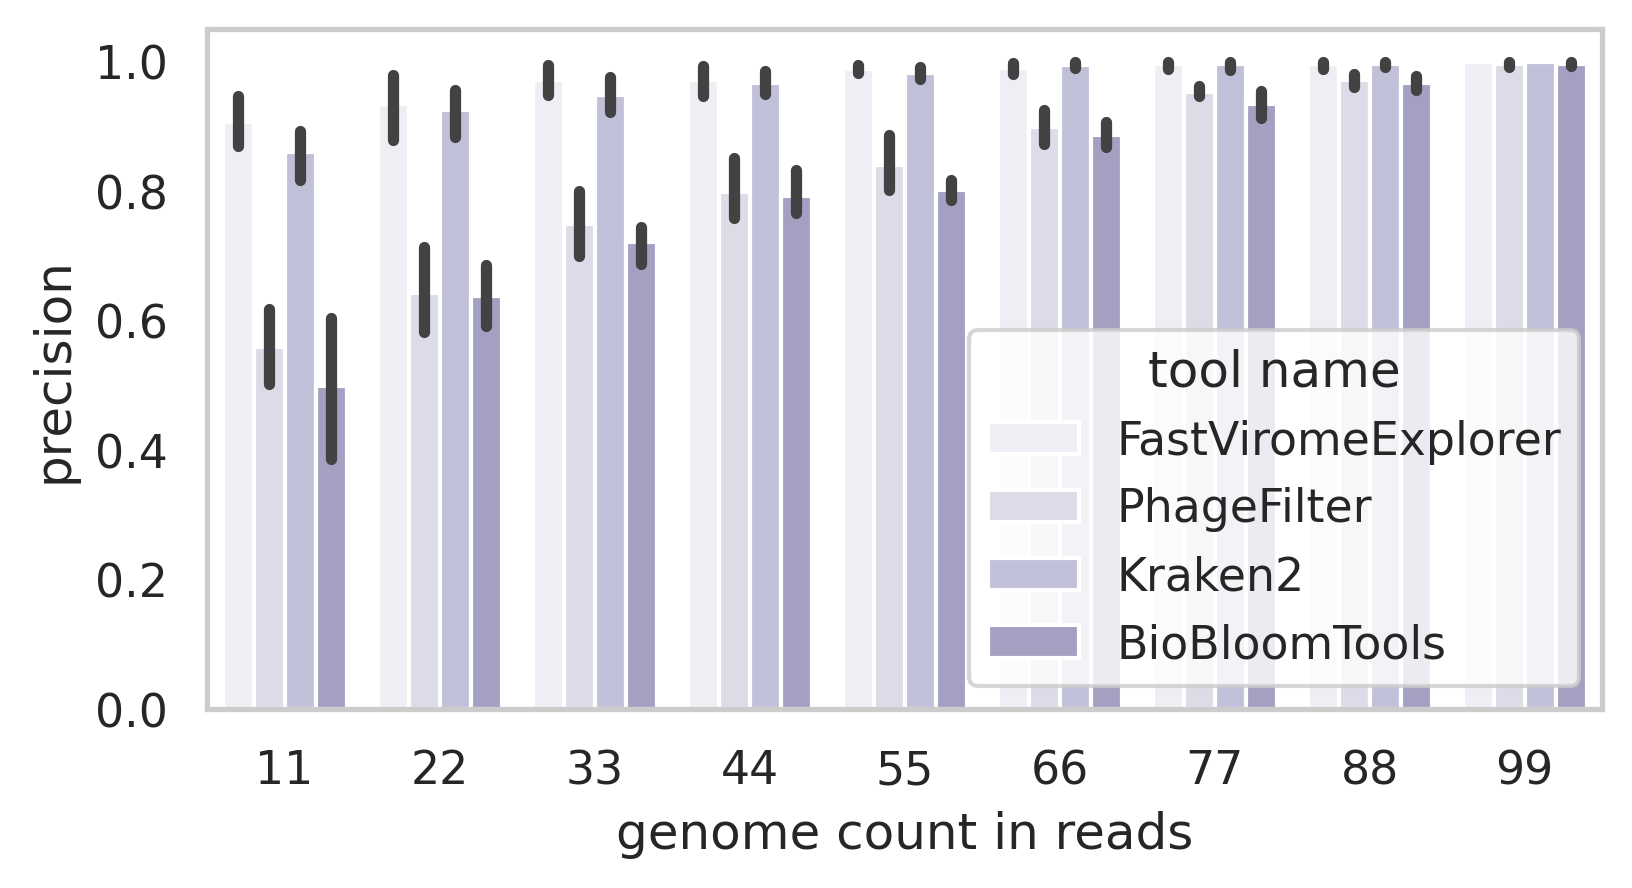

In [709]:
fig, ax1 = plt.subplots(figsize=(6, 3))
ax1.grid(False)
sns.barplot(data=df, x="genome count in reads", y="recall", hue="tool name", palette=project_colors)

fig, ax1 = plt.subplots(figsize=(6, 3))
ax1.grid(False)
sns.barplot(data=df, x="genome count in reads", y="precision", hue="tool name", palette=project_colors)

<AxesSubplot:xlabel='tool name', ylabel='recall'>

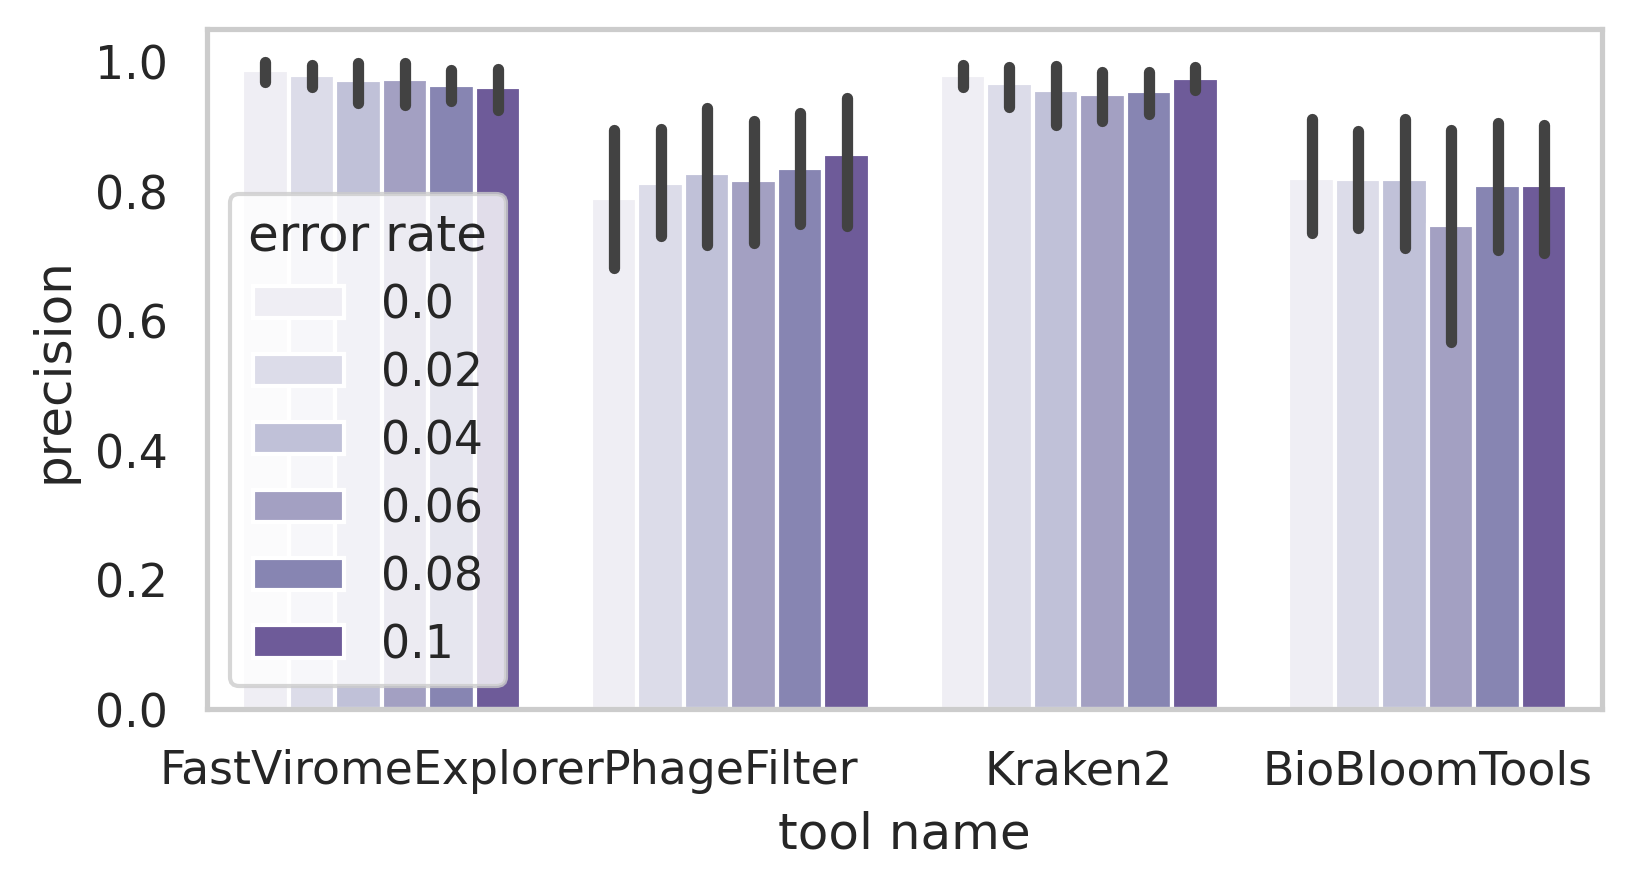

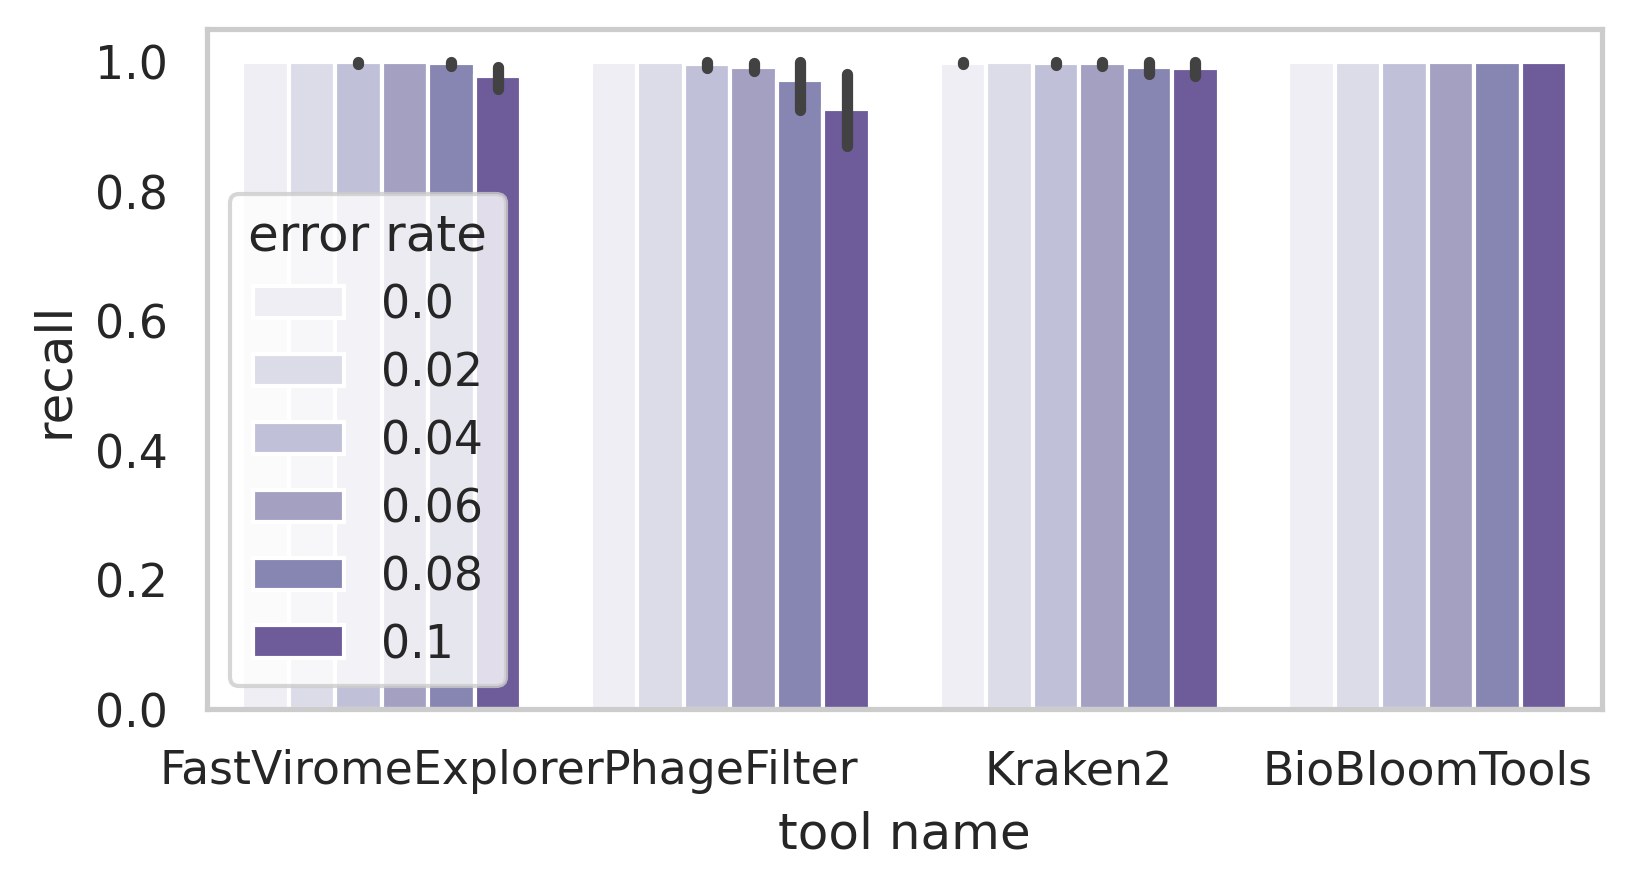

In [710]:
fig, ax1 = plt.subplots(figsize=(6, 3))
ax1.grid(False)
sns.barplot(data=df, x="tool name", y="precision", hue="error rate", palette=project_colors)

fig, ax1 = plt.subplots(figsize=(6, 3))
ax1.grid(False)
sns.barplot(data=df, x="tool name", y="recall", hue="error rate", palette=project_colors)

(0.3, 1.0316666666666667)

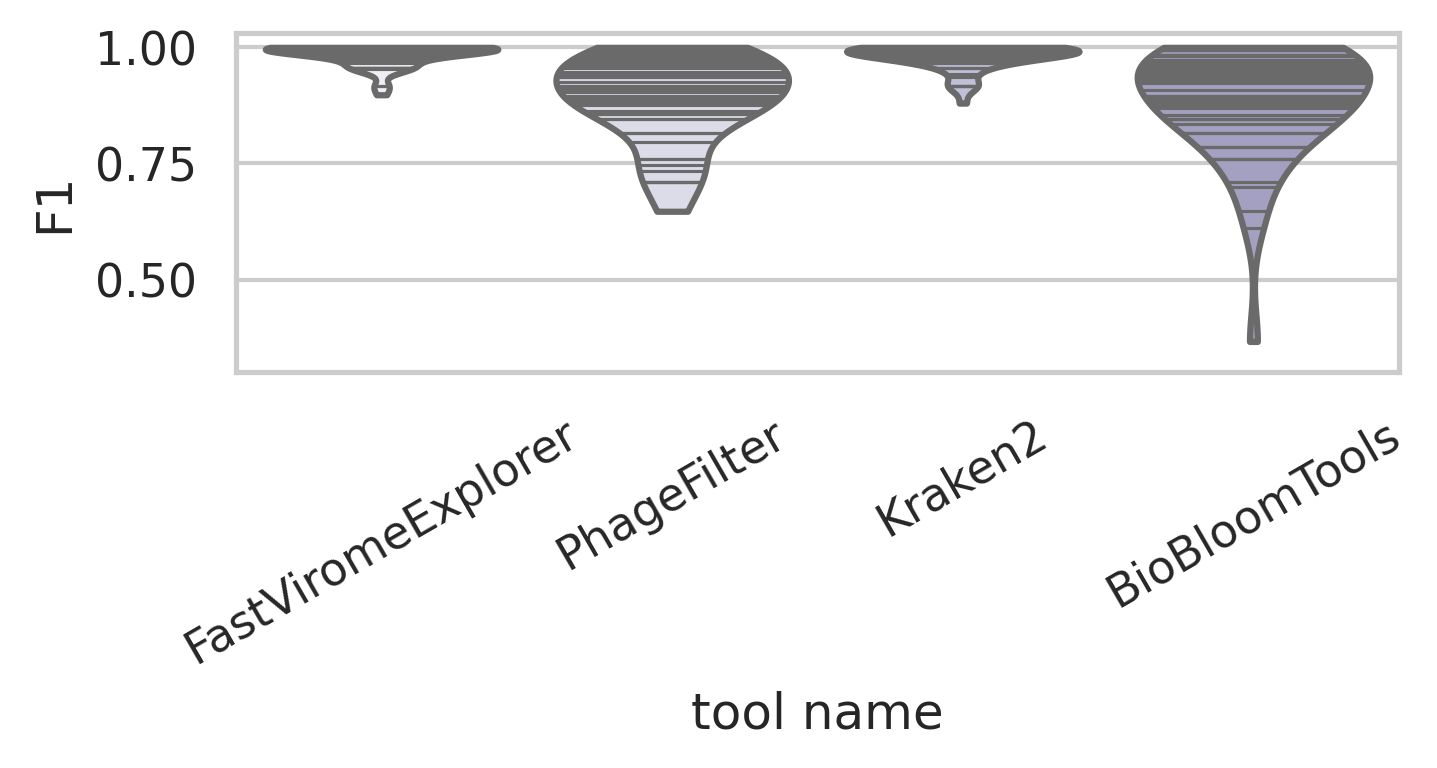

In [711]:
fig, ax1 = plt.subplots(figsize=(5, 1.5))
sns.violinplot(data=df, x="tool name", y="F1", cut=0, inner="stick", palette=project_colors, scale="width", bw=0.5)
ax1.xaxis.set_tick_params(rotation=30)
ax1.set_ylim(bottom=.30)

In [641]:
fig, ax1 = plt.subplots(figsize=(5, 1.5))
sns.violinplot(data=df, x="tool name", y="Mean read count error", cut=0, palette=project_colors, inner="box", bw=1)
ax1.xaxis.set_tick_params(rotation=30)

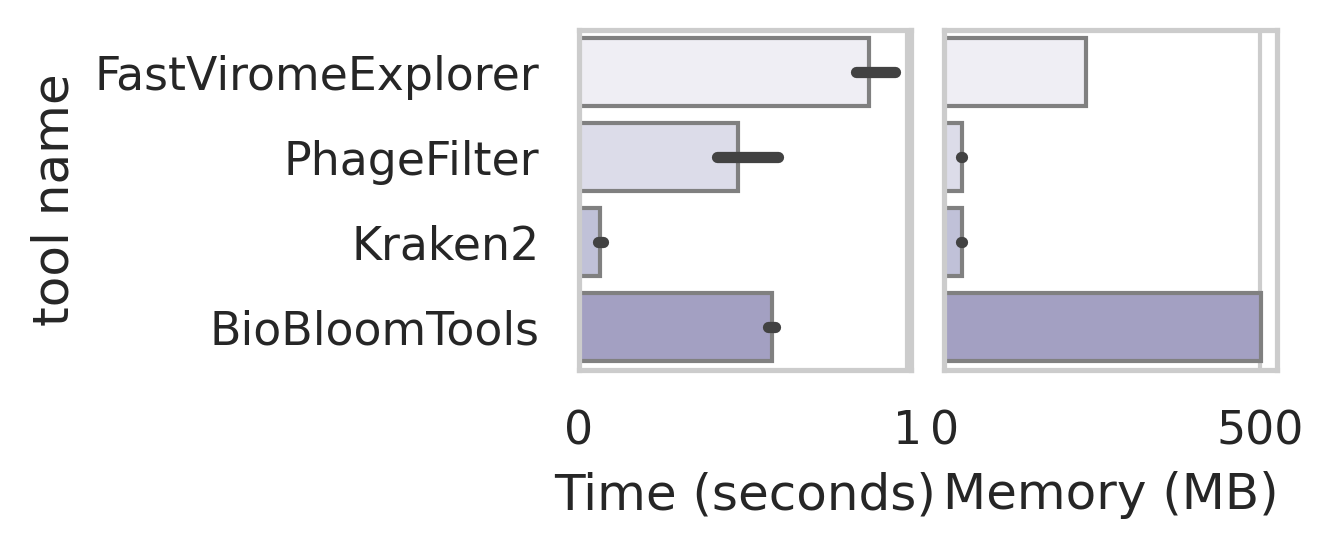

In [642]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a single figure with two subplots arranged in a single row
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(3, 1.5))

# First subplot: Time (seconds)
sns.barplot(data=df, x="Time (seconds)", y="tool name", palette=project_colors, edgecolor=".5", ax=ax1)
ax1.set_xlabel('Time (seconds)')

# Second subplot: Memory (MB)
sns.barplot(data=df, x="Memory (MB)", y="tool name", palette=project_colors, edgecolor=".5", ax=ax2)
ax2.set_xlabel('Memory (MB)')
ax2.set_yticks([])  # Remove the y-axis ticks for the second subplot
ax2.set(ylabel=None)

# Adjust the space between the two subplots
plt.subplots_adjust(wspace=0.1)

# Show the combined plot
plt.show()

---
---
# filter performance
---
---

In [96]:
filter_performance_csv = "../results/res_filter_performance.csv"

In [97]:
# open dataframe
df = csv2dataframe(filter_performance_csv)
df.describe()

contamination percentage  error rate          time         memory  \
count                108.000000  108.000000  1.080000e+02     108.000000   
mean                  73.900000    0.050000  6.935126e+09  198626.962963   
std                   37.678175    0.034316  6.868434e+09  214948.290152   
min                    0.000000    0.000000  1.597422e+08   27484.000000   
25%                   50.000000    0.020000  3.110308e+08   49612.000000   
50%                   97.000000    0.050000  2.834143e+09   53232.000000   
75%                   99.500000    0.080000  1.524940e+10  500728.000000   
max                   99.900000    0.100000  1.753901e+10  500776.000000   

           recall   precision  
count  108.000000  108.000000  
mean     0.815792    0.823005  
std      0.240325    0.230472  
min      0.172000    0.260870  
25%      0.735795    0.738311  
50%      0.938090    0.944890  
75%      0.999000    0.998380  
max      1.000000    1.000000

In [98]:
# data transformations
df["F1"] = 2* df["precision"]*df["recall"] / (df["precision"]+df["recall"])
df["Memory (MB)"] = df["memory"] / (10)**3
df["Time (seconds)"] = df["time"] / (10**9)

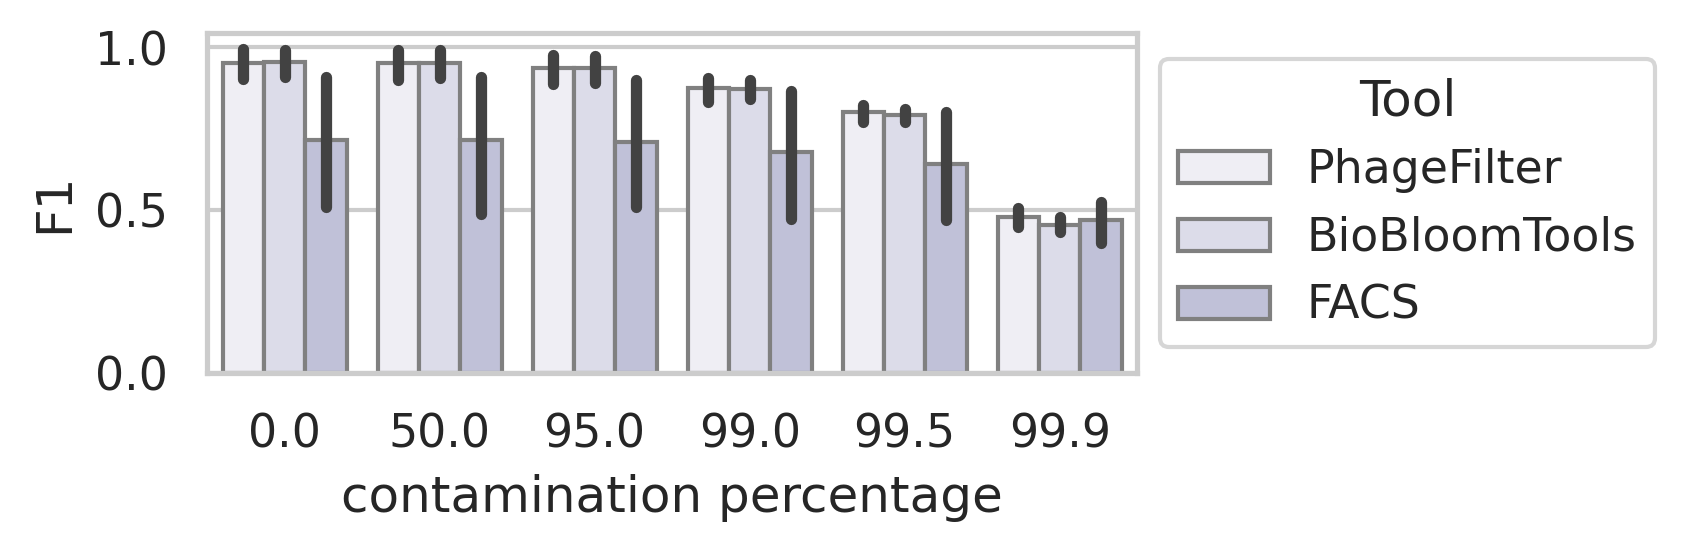

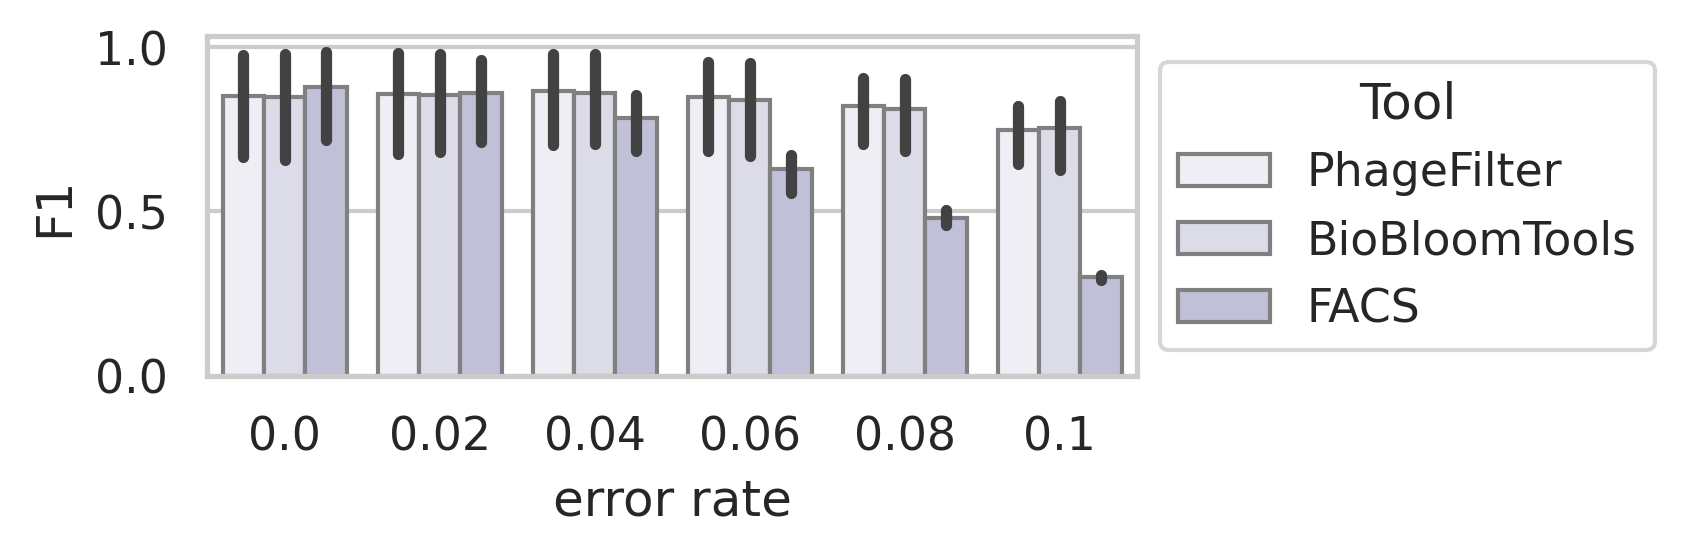

In [99]:
fig, ax1 = plt.subplots(figsize=(4, 1.5))


sns.barplot(data=df, x="contamination percentage", y="F1", hue="tool name",  palette=project_colors, edgecolor=".5")
legend = ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
legend.set_title("Tool")
plt.show()

fig, ax1 = plt.subplots(figsize=(4, 1.5))


sns.barplot(data=df, x="error rate", y="F1", hue="tool name",  palette=project_colors, edgecolor=".5")

legend = ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
legend.set_title("Tool")

plt.show()

---
---
# Memory consumption
---
---

In [375]:
filter_memory_csv = "../results/res_filter_memory.csv"

In [376]:
# open dataframe
df = csv2dataframe(filter_memory_csv)
df.describe()

genome count     read count    build time  build memory  \
count     36.000000      36.000000  3.600000e+01  3.600000e+01   
mean     350.000000   55000.000000  1.421164e+11  4.098386e+06   
std      183.303028   45638.329755  1.031967e+11  3.934020e+06   
min       70.000000   10000.000000  5.566943e+09  1.578640e+05   
25%      210.000000   10000.000000  4.376165e+10  2.303360e+05   
50%      350.000000   55000.000000  1.412553e+11  4.106450e+06   
75%      490.000000  100000.000000  2.379876e+11  7.977540e+06   
max      630.000000  100000.000000  2.865081e+11  7.978332e+06   

       contamination percentage    query time  query memory  
count                      36.0  3.600000e+01     36.000000  
mean                       20.0  8.500148e+09  51910.888889  
std                         0.0  1.381761e+10  14150.309828  
min                        20.0  2.277570e+08  32712.000000  
25%                        20.0  6.775475e+08  43765.000000  
50%                        20.0  1.023420e+09  46172.000000  
75%                        20.0  5.936501e+09  57984.000000  
max                        20.0  4.738575e+10  87172.000000

In [377]:
#df["F1"] = 2* df["precision"]*df["recall"] / (df["precision"]+df["recall"])
df["Memory (MB)"] = df["query memory"] / (10**3)
df["Time (seconds)"] = df["query time"] / (10**9)

df["Build Memory (MB)"] = df["build memory"] / (10**3)
df["Build Time (seconds)"] = df["build time"] / (10**9)

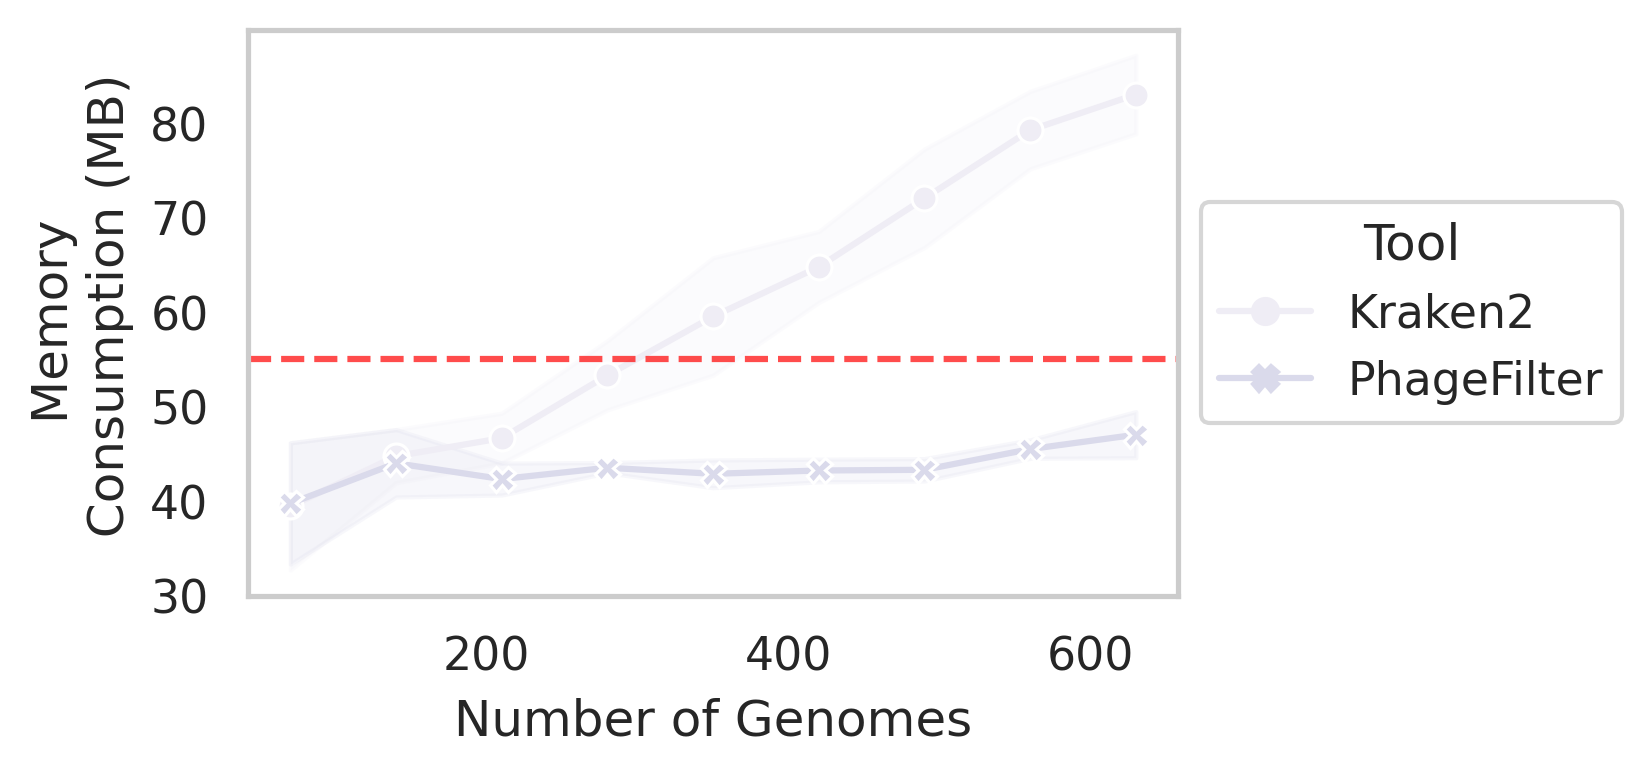

In [378]:
fig, ax1 = plt.subplots(figsize=(4, 2.5))
ax1.grid(False)

# plot
color_count = len(pandas.unique(df["tool name"]))
sns.lineplot(
    data=df,
    x="genome count", y="Memory (MB)", hue="tool name", style="tool name",
    markers=True, dashes=False,
    palette=project_colors[:color_count]
)

ax1.set_xlabel('Number of Genomes')
ax1.set_ylabel('Memory \n Consumption (MB)')

# rasberry pi memory cutoff
ax1.axhline(y=55, linestyle='--', color='red', alpha=0.7)

legend = ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
legend.set_title("Tool")

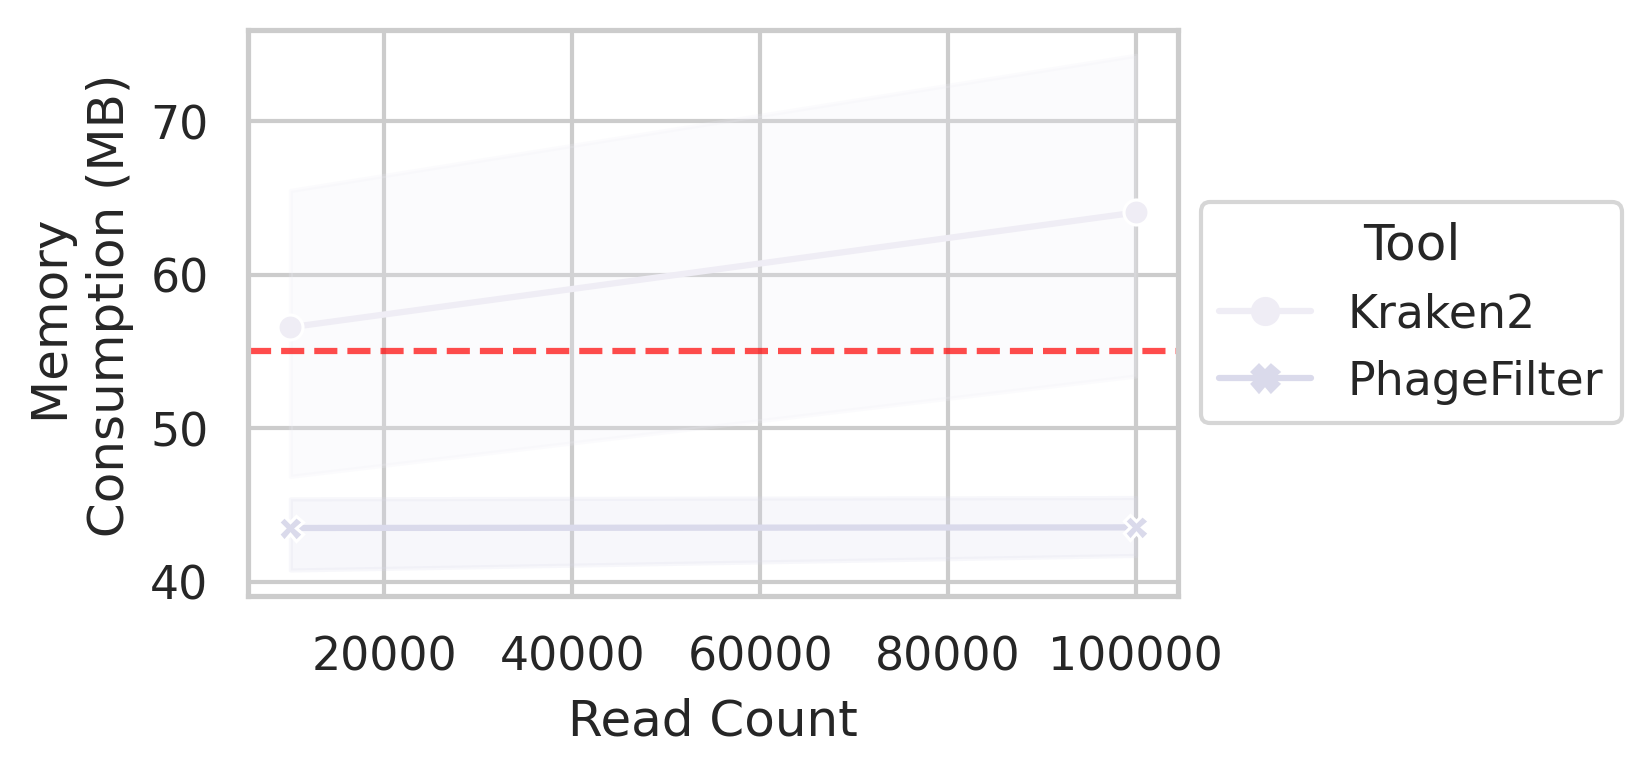

In [379]:
fig, ax1 = plt.subplots(figsize=(4, 2.5))

# plot
color_count = len(pandas.unique(df["tool name"]))
sns.lineplot(
    data=df,
    x="read count", y="Memory (MB)", hue="tool name", style="tool name",
    markers=True, dashes=False,
    palette=project_colors[:color_count]
)

ax1.set_xlabel('Read Count')
ax1.set_ylabel('Memory \n Consumption (MB)')

# rasberry pi memory cutoff
ax1.axhline(y=55, linestyle='--', color='red', alpha=0.7)

legend = ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
legend.set_title("Tool")

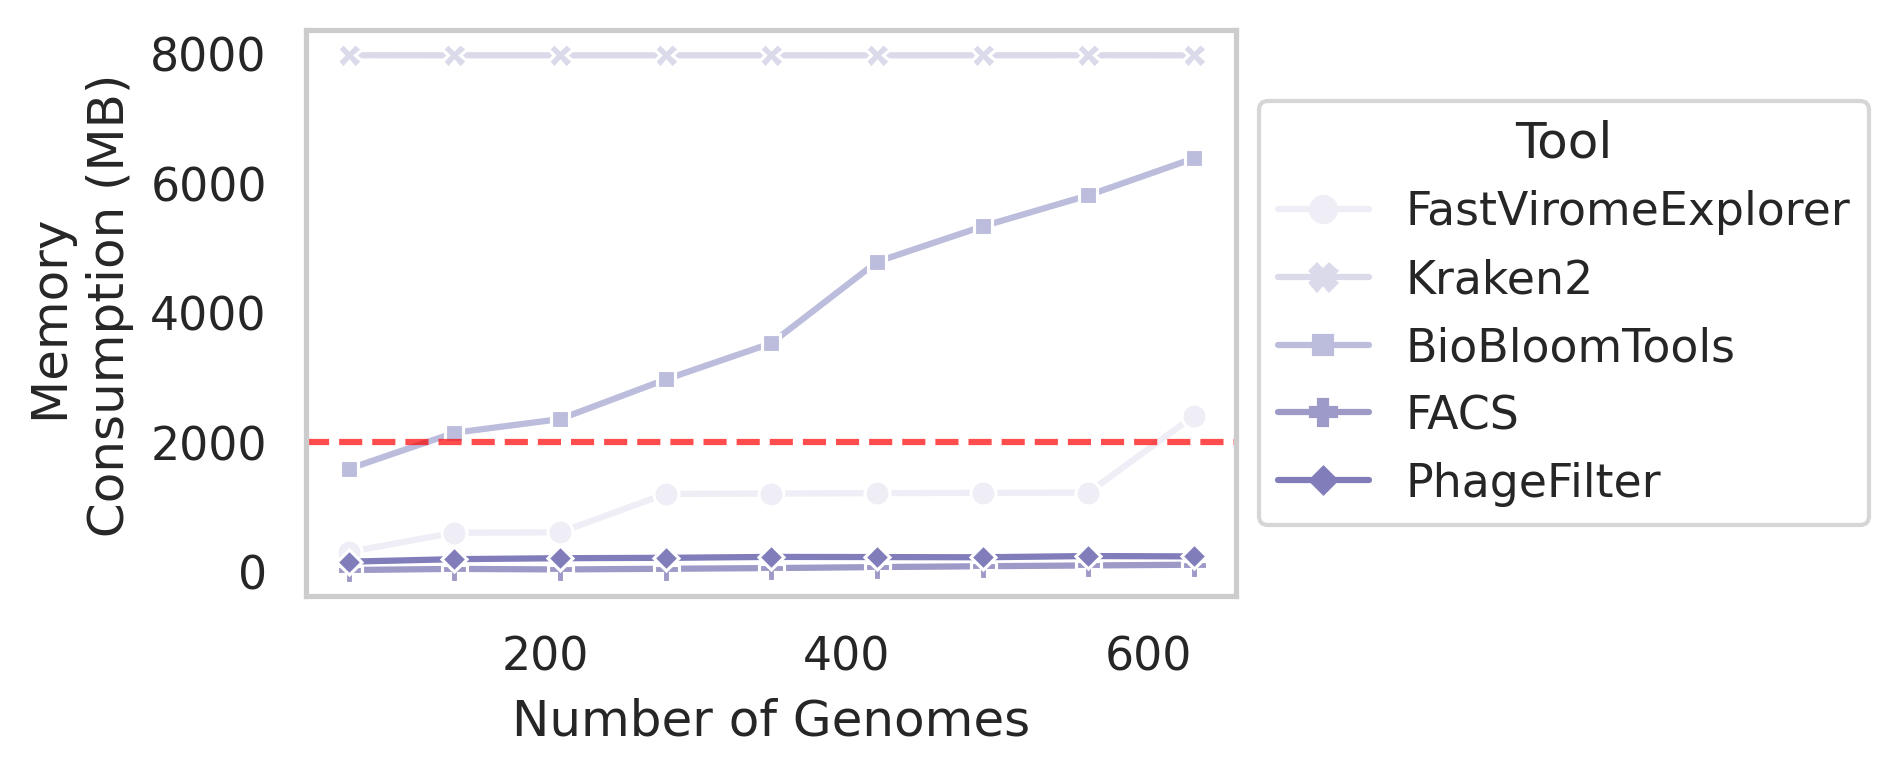

In [374]:
fig, ax1 = plt.subplots(figsize=(4, 2.5))
ax1.grid(False)

# plot
color_count = len(pandas.unique(df["tool name"]))
sns.lineplot(
    data=df,
    x="genome count", y="Build Memory (MB)", hue="tool name", style="tool name",
    markers=True, dashes=False,
    palette=project_colors[:color_count]
)

ax1.set_xlabel('Number of Genomes')
ax1.set_ylabel('Memory \n Consumption (MB)')

# rasberry pi memory cutoff
ax1.axhline(y=2000, linestyle='--', color='red', alpha=0.7)

legend = ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
legend.set_title("Tool")

---
---
# Threading
---
---

In [79]:
threading_csv = "../results/res_threading.csv"

In [80]:
# open dataframe
df = csv2dataframe(threading_csv)
df.describe()

threads  read count  build time (ns)  build memory (bytes)  \
count  12.000000        12.0     1.200000e+01          1.200000e+01   
mean    2.500000   1000000.0     6.539735e+08          3.766204e+07   
std     1.167748         0.0     9.009191e+07          5.363723e+05   
min     1.000000   1000000.0     5.231581e+08          3.675341e+07   
25%     1.750000   1000000.0     5.679364e+08          3.720704e+07   
50%     2.500000   1000000.0     6.592653e+08          3.756851e+07   
75%     3.250000   1000000.0     7.239531e+08          3.817472e+07   
max     4.000000   1000000.0     7.728865e+08          3.836723e+07   

       query time (ns)  query memory (bytes)  
count     1.200000e+01          1.200000e+01  
mean      1.726293e+11          4.751468e+09  
std       4.933637e+10          3.392062e+07  
min       1.168958e+11          4.650496e+09  
25%       1.357246e+11          4.752182e+09  
50%       1.451995e+11          4.763552e+09  
75%       2.308968e+11          4.766047e+09  
max       2.446090e+11          4.776145e+09

In [81]:
# data transformations
df["Build Time (seconds)"] = df["build time (ns)"] / (10**9)
df["Query Time (seconds)"] = df["query time (ns)"]  /  (10**9)

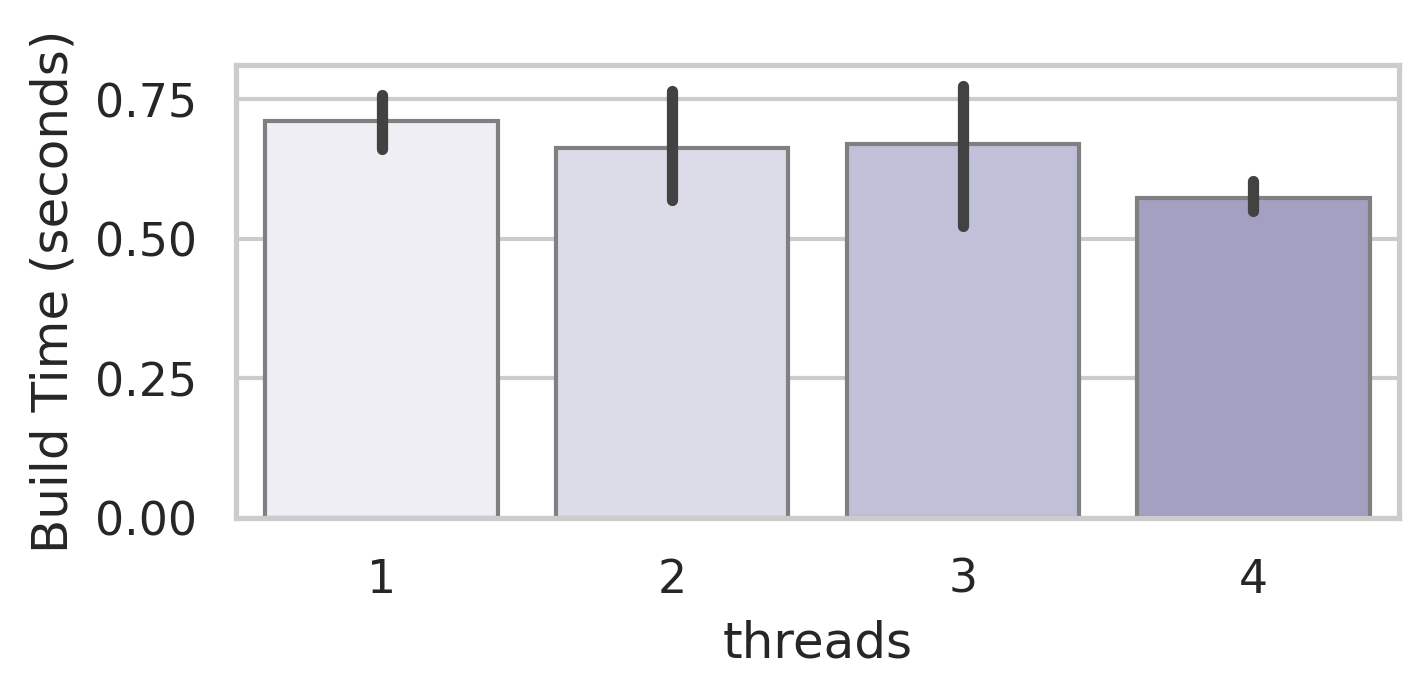

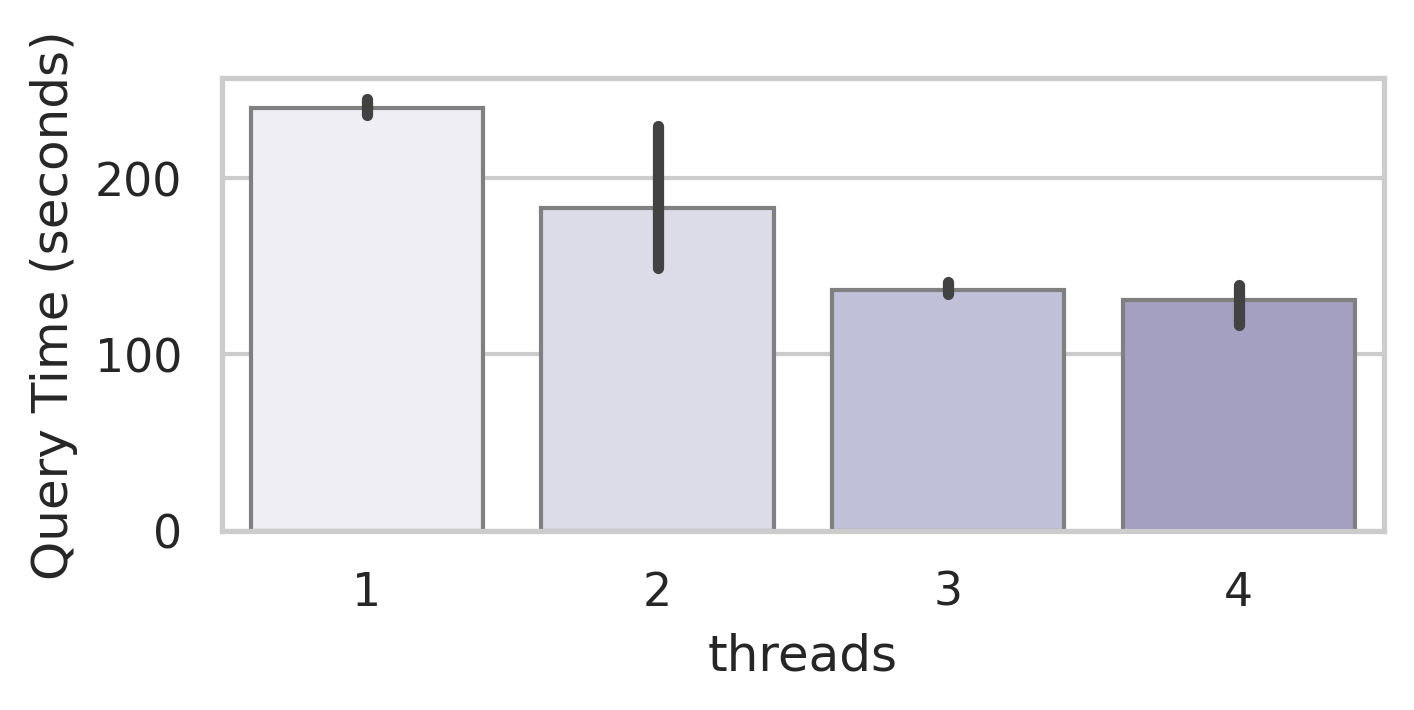

In [82]:
fig, ax1 = plt.subplots(figsize=(5, 2))
#ax2 = ax1.twinx()

# who v/s fare barplot
sns.barplot(x = 'threads',
            y = "Build Time (seconds)",
            data = df,
            palette = project_colors,
            edgecolor=".5")
 
# Show the plot
plt.show()

fig, ax1 = plt.subplots(figsize=(5, 2))
sns.barplot(x = 'threads',
            y = "Query Time (seconds)",
            data = df,
            palette = project_colors,
            edgecolor=".5")

plt.show()

---
---
# Read length 
---
---

In [99]:
readlen_csv = "../results/res_readlength.csv"

In [100]:
# data transformations
df = csv2dataframe(readlen_csv)
df.describe()

genome count   read count   read length  query time (ns)  \
count          10.0     10.00000     10.000000     1.000000e+01   
mean           51.0   5500.00000   2290.000000     2.457922e+09   
std             0.0   4743.41649   4078.452866     4.856822e+09   
min            51.0   1000.00000    100.000000     2.105125e+08   
25%            51.0   1000.00000    150.000000     4.126485e+08   
50%            51.0   5500.00000    200.000000     7.840477e+08   
75%            51.0  10000.00000   1000.000000     1.828190e+09   
max            51.0  10000.00000  10000.000000     1.611112e+10   

       query memory (bytes)  classification recall  classification precision  \
count          1.000000e+01                   10.0                 10.000000   
mean           2.138348e+05                    1.0                  0.684583   
std            3.657201e+05                    0.0                  0.132883   
min            2.771200e+04                    1.0                  0.526316   
25%            3.329400e+04                    1.0                  0.563725   
50%            4.343600e+04                    1.0                  0.669643   
75%            1.181740e+05                    1.0                  0.769231   
max            1.139468e+06                    1.0                  0.909091   

       filter recall  filter precision  
count      10.000000         10.000000  
mean        0.903180          0.998170  
std         0.089012          0.002277  
min         0.782000          0.992386  
25%         0.851100          0.997828  
50%         0.880600          0.998078  
75%         0.997900          0.999950  
max         1.000000          1.000000

In [101]:
# transform
df["Query Memory (MB)"] = df["query memory (bytes)"] / (10)**3
df["Query Time (seconds)"] = df["query time (ns)"] / (10**9)
df["classification F1"] = 2* df["classification precision"]*df["classification recall"] / (df["classification precision"]+df["classification recall"])
df["filter F1"] = 2* df["filter precision"]*df["filter recall"] / (df["filter precision"]+df["filter recall"])

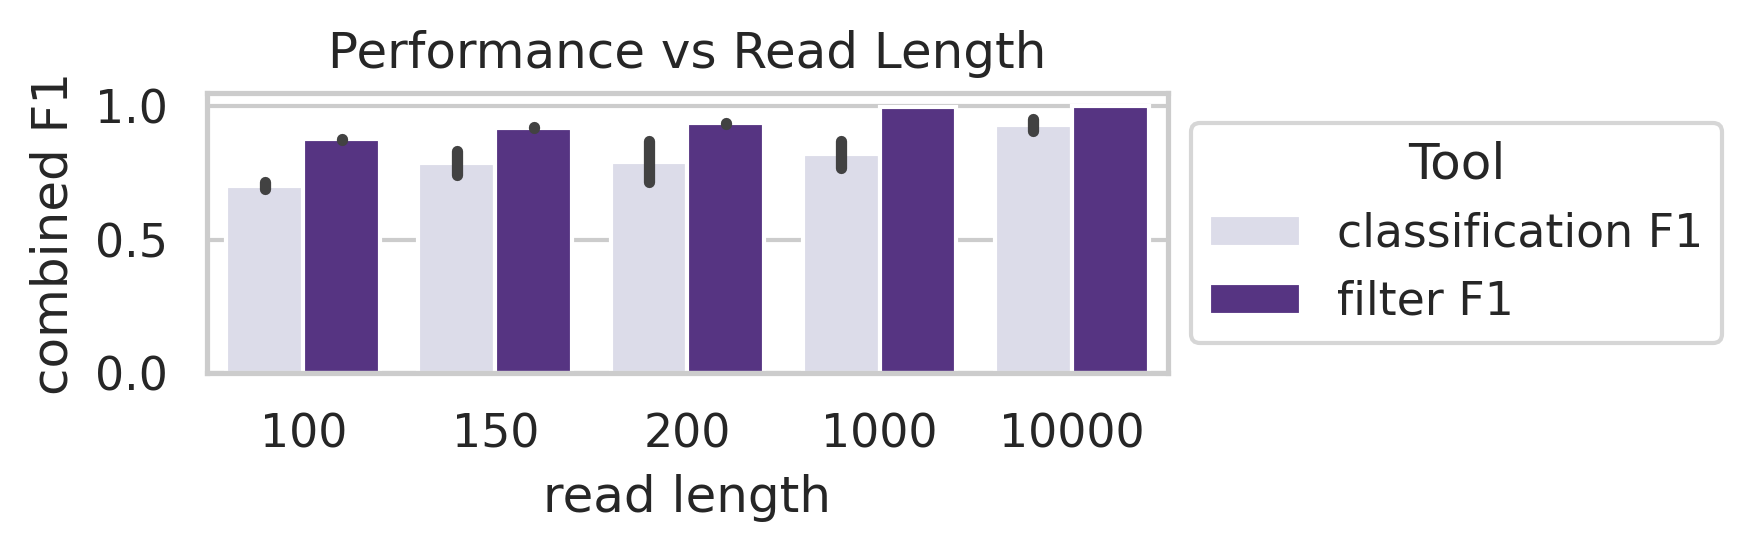

In [105]:
import matplotlib.pyplot as plt
import seaborn as sns

# First, melt the dataframe to have a single 'precision' column and a new column for the type (classification or filter)
df_melted = df.melt(id_vars='read length', value_vars=["classification F1", "filter F1"], 
                    var_name='F1', value_name='combined F1')

fig, ax = plt.subplots(figsize=(6, 2))

# Combined barplot
sns.barplot(x='read length',
            y='combined F1',
            hue='F1', 
            data=df_melted,
            palette=[project_colors[1], project_colors[6]],
            ax=ax)

# put legend on the rightside
legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
legend.set_title("Tool")

ax.set_title('Performance vs Read Length')

plt.tight_layout()  # Adjust the layout to prevent overlapping
plt.show()

---
---
# Depth testing
---
---

In [190]:
depth_csv = "../results/res_depth.csv"

In [191]:
# open dataframe
df = csv2dataframe(depth_csv)
df.describe()

replicate  tree depth  genome count      error          time  \
count  72.000000   72.000000          72.0  72.000000  7.200000e+01   
mean    1.000000    3.500000         100.0   0.020000  5.233764e+09   
std     0.822226    2.307367           0.0   0.016445  1.453286e+09   
min     0.000000    0.000000         100.0   0.000000  3.110968e+09   
25%     0.000000    1.750000         100.0   0.000000  3.624826e+09   
50%     1.000000    3.500000         100.0   0.020000  5.652793e+09   
75%     2.000000    5.250000         100.0   0.040000  6.426262e+09   
max     2.000000    7.000000         100.0   0.040000  7.279655e+09   

       filter recall  filter precision  
count      72.000000         72.000000  
mean        0.972491          0.758162  
std         0.046893          0.383075  
min         0.871242          0.099820  
25%         0.987275          0.724292  
50%         0.999649          0.983445  
75%         1.000000          0.987181  
max         1.000000          0.988417

In [192]:
# transform
df["Query Time (seconds)"] = df["time"] / (10**9)
df = df[df["tree depth"] <= 3]

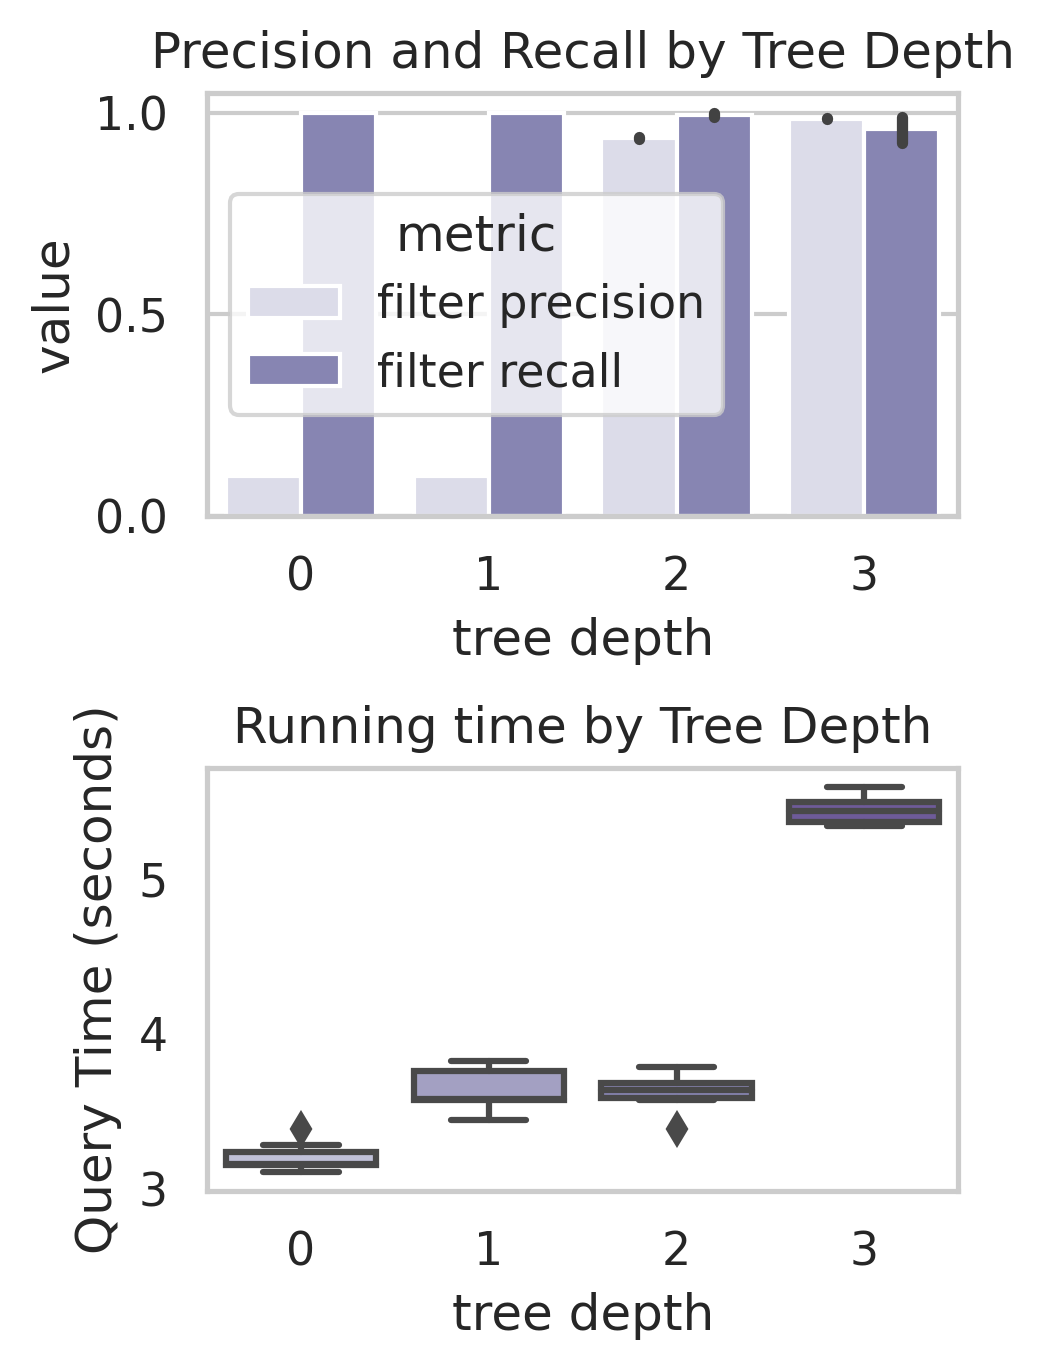

In [193]:
fig, axes = plt.subplots(2, 1, figsize=(4, 5))

fig.tight_layout(pad=3)

# Melt the DataFrame into a long format
df_melted = df.melt(id_vars='tree depth', value_vars=['filter precision', 'filter recall'], var_name='metric', value_name='value')

# Plot the bar chart with both precision and recall
sns.barplot(data=df_melted, x="tree depth", y="value", hue="metric", palette=[project_colors[1], project_colors[4]], ax=axes[0])
# legend = axes[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
legend.set_title("Metric")
axes[0].set_title('Precision and Recall by Tree Depth')

# plot time
sns.boxplot(data=df, x="tree depth", y="Query Time (seconds)", palette=project_colors[2:], ax=axes[1])
axes[1].set_title('Running time by Tree Depth')
axes[1].grid(False)

plt.subplots_adjust(wspace=10) 

# Display the plot
plt.show()